# Dutch street network sandbox

In [1]:
import matplotlib.pyplot as plt
from pprint import pprint
from collections import defaultdict
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np
import osmnx as ox
import networkx as nx
import pandas as pd
import copy
import os

# Geopandas modules
import geopandas as gpd
from geopandas.tools import sjoin
from shapely.geometry import Point # Create point from (lon, lat)
from shapely.geometry import Polygon, MultiPolygon
from descartes import PolygonPatch

Selected geodata from The Netherlands ([Wijk- en buurtkaart 2019](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/wijk-en-buurtkaart-2019)) and cross with income data ([CBS 2017](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=83765NED&_theme=230)).

In [2]:
# Data sources
# https://geoservices.zuid-holland.nl

# Graph name
city = "Rotterdam"

# Region
region = "Rotterdam, The Netherlands"

# Assumption = People in Rotterdam Zuid have distinct travel patterns
zuid_districts = ["Charlois", "IJsselmonde", "Feijenoord"]

# Filter districts
district_filter = ["Hoek van Holland", "Rozenburg", "Pernis", "Hoogvliet", "Waalhaven-Eemhaven"]

# Filter neighborhoods
neighborhood_filter_list = ["Heijplaat", "Noord Kethel", "Schieveen"]

speed_km_h = 20
max_travel_time_edge = 30 # seconds at speed_km_h

graph_name = region.lower().replace(" ", "-").replace(",", "")
graph_filename = f"{graph_name}.graphml"
city_name = city.lower().replace(" ","_")

# Directory where data will be saved (absolute path is necessary)
directory = "C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/"

# Where input NL data is saved
directory_data = "../notebooks/data/nl/"

# Folders
folder_data = f"{directory}data/"
folder = f"{directory}output/{city_name}/"
folder_network = f"{folder}network/"
folder_img = f"{folder}figures/"
folder_shp = f"{folder}shp/"
folder_shp_districts = f"{folder_shp}districts/"
folder_shp_neighborhoods = f"{folder_shp}neighborhoods/"
folder_shp_points = f"{folder_shp}points/"

folder_list = [
    folder_img,
    folder_shp,
    folder_shp_districts,
    folder_shp_neighborhoods,
    folder_shp_points
]

pprint(folder_list)

# Creating folder1s
for f in folder_list:
    if not os.path.exists(f):
        os.makedirs(f)

# Imgs
path_img_network_original = f"{folder_img}street_network_original.pdf"
path_img_street_network_points = f"{folder_img}street_network_points.pdf"
path_img_street_network_points_cleaned = f"{folder_img}street_network_points_cleaned.pdf"
path_img_street_network_neighbors=f"{folder_img}street_network_neighbors.pdf"
path_hexbins = f"{folder_img}hexbins.pdf"
path_overlay_hexbins = f"{folder_img}overlay_hexbins.pdf"
path_station_noord_zuid = f"{folder_img}station_noord_zuid.pdf"
path_img_residents = f"{folder_img}residents.pdf"

### Dataframes
path_node_hex = f"{folder}{city_name}_node_hex.csv"
path_node_station_hex = f"{folder}{city_name}_node_station_hex.csv"
path_bus_stops = f"{folder}{city_name}_bus_stops.csv"
path_nodes_dist_neigh = f"{folder}{city_name}_nodes_dist_neigh.csv"
network_path = f"{folder}{graph_name}.graphml"
path_dist_matrix_npy = f"{folder_network}distance_matrix_m.npy"

### Shapes
path_shp_districts = f"{folder_shp_districts}{city_name}_districts.shp"
path_city_geopoints = f"{folder_shp_points}{city_name}_network_points.shp"
path_shp_neighborhoods = f"{folder_shp_neighborhoods}{city_name}_neighborhoods.shp"

### Input data
path_stations = f"{directory_data}nl_train_stations.csv" # Train stations
path_stats = f"{directory_data}nl_census_2017.csv" # Dutch stats
path_stops = f"{directory_data}nl_bus_stops.csv" # Bus stops

# Filter minimum population size
min_pop = 1000
year_stats = 2017

# Get district and neighbor paths
paths = {
    2019:("2019/buurt_2019_v1.shp" , "2019/wijk_2019_v1.shp", "2019/gemeente_2019_v1.shp"),
    2017:("2017/buurt_2017_v3.shp" , "2017/wijk_2017_v3.shp", "2017/gemeente_2017_v3.shp")
}
paths = {k:(f"{directory_data}nl_district_neighbors/{s}" for s in v) for k,v in paths.items()}

# Path neighborhood (buurten) data AND Path district (wijken) data
neighborhood_shp, district_shp, gemeente_shp  = paths[2019]

# Loading districts and neighborhoods
shapefile_wijk = gpd.read_file(district_shp)
shapefile_buurt = gpd.read_file(neighborhood_shp)
shapefile_gemeente = gpd.read_file(gemeente_shp)

['C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/figures/',
 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/shp/',
 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/shp/districts/',
 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/shp/neighborhoods/',
 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/shp/points/']


In [3]:
print("BU:", list(shapefile_buurt.keys()))
print("WK:", list(shapefile_wijk.keys()))
print("GE:", list(shapefile_gemeente.keys()))

BU: ['BU_CODE', 'JRSTATCODE', 'BU_NAAM', 'WK_CODE', 'WK_NAAM', 'GM_CODE', 'GM_NAAM', 'IND_WBI', 'WATER', 'POSTCODE', 'DEK_PERC', 'OAD', 'STED', 'BEV_DICHTH', 'AANT_INW', 'AANT_MAN', 'AANT_VROUW', 'P_00_14_JR', 'P_15_24_JR', 'P_25_44_JR', 'P_45_64_JR', 'P_65_EO_JR', 'P_ONGEHUWD', 'P_GEHUWD', 'P_GESCHEID', 'P_VERWEDUW', 'AANTAL_HH', 'P_EENP_HH', 'P_HH_Z_K', 'P_HH_M_K', 'GEM_HH_GR', 'P_WEST_AL', 'P_N_W_AL', 'P_MAROKKO', 'P_ANT_ARU', 'P_SURINAM', 'P_TURKIJE', 'P_OVER_NW', 'OPP_TOT', 'OPP_LAND', 'OPP_WATER', 'geometry']
WK: ['WK_CODE', 'JRSTATCODE', 'WK_NAAM', 'GM_CODE', 'GM_NAAM', 'IND_WBI', 'WATER', 'OAD', 'STED', 'BEV_DICHTH', 'AANT_INW', 'AANT_MAN', 'AANT_VROUW', 'P_00_14_JR', 'P_15_24_JR', 'P_25_44_JR', 'P_45_64_JR', 'P_65_EO_JR', 'P_ONGEHUWD', 'P_GEHUWD', 'P_GESCHEID', 'P_VERWEDUW', 'AANTAL_HH', 'P_EENP_HH', 'P_HH_Z_K', 'P_HH_M_K', 'GEM_HH_GR', 'P_WEST_AL', 'P_N_W_AL', 'P_MAROKKO', 'P_ANT_ARU', 'P_SURINAM', 'P_TURKIJE', 'P_OVER_NW', 'OPP_TOT', 'OPP_LAND', 'OPP_WATER', 'geometry']
GE: 

Columns filtered:

|  Column    | Description                         |
|-----------:|:------------------------------------|
|`GM_NAAM`   |Gemeentenaam                         |
|`WK_NAAM`   |Wijknaam                             |
|`BU_NAAM`   |Buurtnaam                            |
|`AANT_INW`  |Aantal inwoners                      |
|`P_15_24_JR`|Percentage personen 15 tot 25 jaar   |
|`P_25_44_JR`|Percentage personen 25 tot 45 jaar   |
|`P_45_64_JR`|Percentage personen 45 tot 65 jaar   |
|`P_65_EO_JR`|Percentage personen 65 jaar en ouder |
|`BEV_DICHTH`|aantal inwoners per km2              |
|`geometry`  |geodata (multi-polygon)              |


Filter districts by: city, min. population and district black list.

In [4]:
# Filter columns
shapefile_wijk = shapefile_wijk[[
    "GM_NAAM",
    "WK_CODE",
    "WK_NAAM",
    "AANT_INW",
    #"BEV_DICHTH",
    #"P_15_24_JR",
    #"P_25_44_JR",
    #"P_45_64_JR",
    #"P_65_EO_JR",
    "geometry"
]]

# Filters
city_filter = (shapefile_wijk["GM_NAAM"]==city) # Geement Naam = City
min_pop_filter = (shapefile_wijk["AANT_INW"]>=min_pop) # Aantal inwoners = N. of inhabitants
district_filter = (~shapefile_wijk["WK_NAAM"].isin(district_filter)) # Wijk naam = District name

# Filtered districts
wijk_shp = shapefile_wijk[city_filter & min_pop_filter & district_filter]

# Show data
population = sum(set(wijk_shp["AANT_INW"]))
districts = set(wijk_shp["WK_NAAM"])
print(f"Districts from {city} with more than {min_pop:,} inhabitants:")
pprint(districts)

Districts from Rotterdam with more than 1,000 inhabitants:
{'Charlois',
 'Delfshaven',
 'Feijenoord',
 'Hillegersberg-Schiebroek',
 'IJsselmonde',
 'Kralingen-Crooswijk',
 'Noord',
 'Overschie',
 'Prins Alexander',
 'Rotterdam Centrum'}


Filter neighborhood data:

In [5]:
# Filter columns
shapefile_buurt = shapefile_buurt[[
    "GM_NAAM",
    "WK_NAAM",
    "BU_CODE",
    "BU_NAAM",
    "AANT_INW",
    #"BEV_DICHTH",
    #"P_15_24_JR",
    #"P_25_44_JR",
    #"P_45_64_JR",
    #"P_65_EO_JR",
    "geometry"
]]

district_filter = (shapefile_buurt["WK_NAAM"].isin(districts))
city_filter = (shapefile_buurt["GM_NAAM"]==city)
neighborhood_filter = (~shapefile_buurt["BU_NAAM"].isin(neighborhood_filter_list))
#min_pop_filter = (shapefile_buurt["AANT_INW"]>=min_pop) # Aantal inwoners = N. of inhabitants

buurt_shp = shapefile_buurt[city_filter & district_filter & neighborhood_filter]

# Show data
neighborhoods = set(buurt_shp["BU_NAAM"])
print(f"Neighborhoods from '{city}' within the selected districts:")
print(list(neighborhoods))

Neighborhoods from 'Rotterdam' within the selected districts:
['Oude Noorden', 'Wielewaal', 'Oud IJsselmonde', 'Bospolder', 'Kralingseveer', 'Nesselande', 'Zuidwijk', 'Zestienhoven', 'Kralingse Bos', 'Pendrecht', 'Feijenoord', 'Oud Crooswijk', 'Kralingen West', 'Zuidplein', 'Ommoord', 'Kralingen Oost', 'Bergpolder', 'Delfshaven', 'Struisenburg', 'Zevenkamp', 'Oude Westen', 'Nieuwe Westen', 'Spangen', 'Tarwewijk', 'Vreewijk', 'Oud Mathenesse', 'Beverwaard', 'Blijdorp', 'Schiebroek', 'Cs Kwartier', 'Liskwartier', 'Rubroek', 'Cool', 'Groot IJsselmonde', "'s Gravenland", 'Terbregge', 'Prinsenland', 'Nieuwe Werk', 'Stadsdriehoek', 'Provenierswijk', 'Tussendijken', 'Molenlaankwartier', 'Charlois Zuidrand', 'Noordereiland', 'Kop van Zuid', 'Kop van Zuid - Entrepot', 'Hillegersberg Noord', 'Afrikaanderwijk', 'Oud Charlois', 'Witte Dorp', 'Overschie', 'Agniesebuurt', 'Blijdorpsepolder', 'Hillegersberg Zuid', 'Oosterflank', 'Katendrecht', 'Dijkzigt', 'Schiemond', 'Nieuw Crooswijk', 'Lombardijen'

In [6]:
buurt_shp

,GM_NAAM,WK_NAAM,BU_CODE,BU_NAAM,AANT_INW,geometry
6718,Rotterdam,Rotterdam Centrum,BU05990110,Stadsdriehoek,16390,"POLYGON ((92349.580 437925.056, 92375.713 4379..."
6719,Rotterdam,Rotterdam Centrum,BU05990111,Oude Westen,9445,"POLYGON ((91412.788 437507.740, 91415.880 4375..."
6720,Rotterdam,Rotterdam Centrum,BU05990112,Cool,5735,"POLYGON ((91925.500 437499.710, 91933.681 4375..."
6721,Rotterdam,Rotterdam Centrum,BU05990113,Cs Kwartier,1020,"POLYGON ((92326.078 437923.110, 92329.379 4379..."
6722,Rotterdam,Rotterdam Centrum,BU05990118,Nieuwe Werk,1755,"POLYGON ((92366.606 436291.783, 92369.250 4362..."
...,...,...,...,...,...,...
6785,Rotterdam,Charlois,BU05991574,Oud Charlois,13760,"POLYGON ((91162.000 434931.000, 91176.872 4349..."
6786,Rotterdam,Charlois,BU05991575,Wielewaal,420,"POLYGON ((91205.945 433249.497, 91227.890 4332..."
6787,Rotterdam,Charlois,BU05991576,Zuidplein,1265,"POLYGON ((93046.460 433834.390, 93049.450 4338..."
6788,Rotterdam,Charlois,BU05991577,Pendrecht,12390,"POLYGON ((90875.580 431872.570, 90940.980 4319..."


## Population in districts and neighborhoods

In [7]:
buurt_shp["share_residents"] = buurt_shp["AANT_INW"]/sum(buurt_shp["AANT_INW"])
wijk_shp["share_residents"] = wijk_shp["AANT_INW"]/sum(wijk_shp["AANT_INW"])

C:\Users\LocalAdmin\anaconda3\envs\env_slevels\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\LocalAdmin\anaconda3\envs\env_slevels\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


MAX: 0.16468636082261504
MAX: 0.049607026080354756


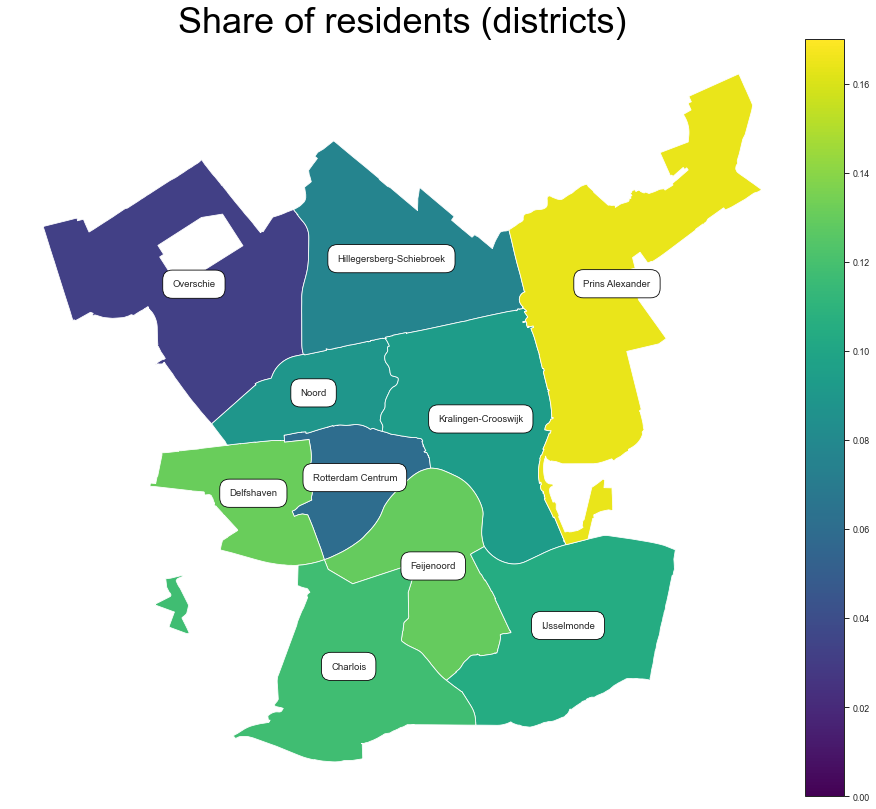

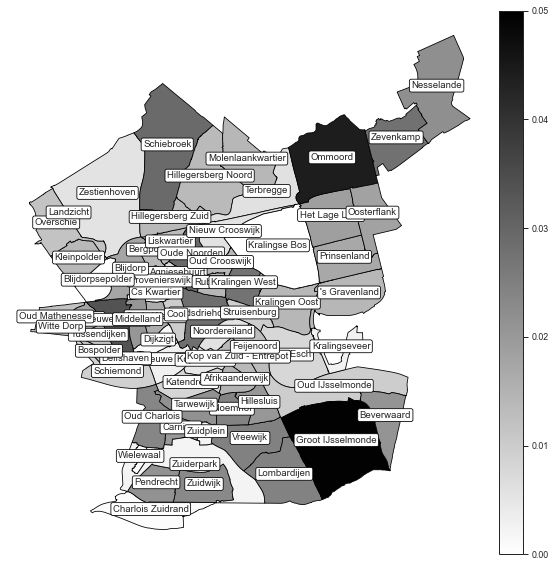

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig_w, ax_w = plt.subplots(1, 1, figsize=(15, 15))

sns.set_style("white")
sns.set_context("paper")


# Color based on
color_column = "share_residents"
# Setup population bar from districts
divider1 = make_axes_locatable(ax_w)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)

print("MAX:", max(wijk_shp[color_column]))
wijk_shp.plot(column=color_column, cmap="viridis",  vmin=0, vmax=0.17, ax=ax_w, legend=True, cax=cax1)
ax_w.axis("off")
ax_w.set_title("Share of residents (districts)", fontsize=36)


# Annotate district names
_ = wijk_shp.apply(
        lambda x: ax_w.annotate(
            s=x.WK_NAAM,
            xy=x.geometry.centroid.coords[0],
            ha='center',
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                boxstyle='round,pad=1'
            )
        ),
        axis=1
    )

fig_res, ax_res = plt.subplots(1, 1, figsize=(10, 10))

# Annotate neighborhood names
_ = buurt_shp.apply(
        lambda x: ax_res.annotate(
            s=x.BU_NAAM,
            xy=x.geometry.centroid.coords[0],
            ha='center',
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                boxstyle='round,pad=0.2'
            )
        ),
        axis=1
    )

# Setup population bar from neighborhoods
print("MAX:", max(buurt_shp[color_column]))
divider2 = make_axes_locatable(ax_res)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
buurt_shp.plot(column=color_column, cmap="binary", edgecolor="black", legend=True, vmin=0, vmax=0.05, ax=ax_res, cax=cax2)


ax_res.axis("off")
#ax[1].set_title("Number of residents (neighborhoods)", fontsize=28)


fig_res.savefig(path_img_residents, bbox_inches="tight", pad_inches=0)

## Plot network over geographic areas

Get the street network graph of the city from openstreetmaps:


In [9]:
G_original = ox.graph_from_place(region, network_type="drive", simplify=True)

In [10]:
import sys
import logging
logging.basicConfig(level=logging.INFO)

# Network module includes the "clean_network" function
# to get the largest strongly connected graph.

sys.path.insert(0, "../../tenv/tenv/")
import network as nw

# Get network graph and save
G = nw.get_network_from(
    region,
    folder_network,
    graph_name,
    graph_filename,
    max_travel_time_edge,
    speed_km_h,
)

nw.save_graph_pic(G, folder_img)

INFO:root:Loading C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/network/rotterdam-the-netherlands.graphml
INFO:root:Network is not in 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/network/rotterdam-the-netherlands.graphml'
INFO:root:Loading graph from 'Rotterdam, The Netherlands'...
INFO:root:#NODES: 11245 (26673101 -> 7706832370) -- #EDGES: 25387
INFO:root:Size of strongly connected components: [11027, 1, 1, 1, 1, 1, 1, 1, 1]
INFO:root:Cleaning network...
INFO:root:#NODES: 11027 (26673101 -> 7706832370) -- #EDGES: 24546
INFO:root:Enriching graph (max_trave_time_edge=1, speed_km_h=20)...
INFO:root:#NODES: 45204 (11027 -> 7706832370) -- #EDGES: 42321
INFO:root:Cleaning enriched network...
INFO:root:Size of strongly connected components: [359, 185, 125, 122, 116, 111, 109, 106, 104, 102, 101, 100, 100, 97, 97, 96, 91, 91, 89, 87, 86, 85, 85, 83, 81, 81, 80, 79, 79, 79, 79, 77, 75, 75, 74,

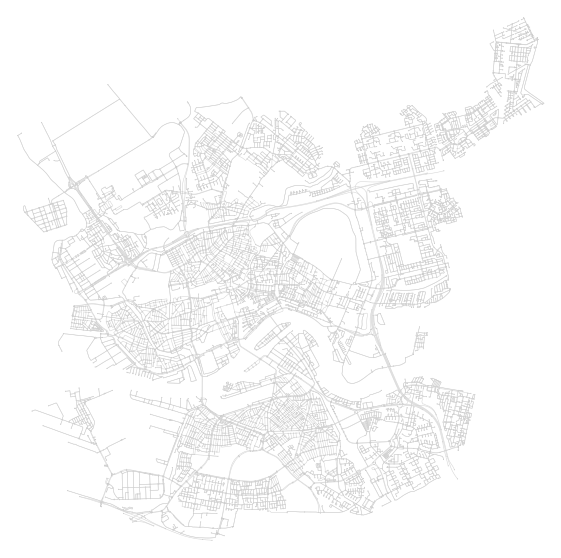

In [11]:
# Project graph using Dutch CRS
G_proj_original = ox.project_graph(G_original, to_crs=('EPSG:28992'))

# Plot street network projection
fig, ax = ox.plot_graph(
    G_proj_original,
    fig_height=10,
    node_color="#C0C0C0",
    node_size=1,
    edge_linewidth=0.5,
    node_zorder=0,
    edge_color="#D3D3D3",
    show=False,
    close=False,
)#, node_edgecolor='k', edge_color='#777777')

fig.savefig(path_img_network_original, bbox_inches="tight", pad_inches=0)

### Dataframe from street network

Create a geopandas dataframe from graph nodes (node id, lon, lat):

In [12]:
data = defaultdict(list)
for n in G_original.nodes():
    data["id"].append(n)
    x=G_original.nodes[n]["x"]
    y=G_original.nodes[n]["y"]
    data["lon"].append(x)
    data["lat"].append(y)

df_points = pd.DataFrame.from_dict(data)
geometry = [Point(xy) for xy in zip(df_points.lon, df_points.lat)]

# geopandas from graph
geo_points = gpd.GeoDataFrame(df_points, geometry=geometry, crs="EPSG:4326")
geo_points = geo_points.to_crs('EPSG:28992')

Add district and neighborhood names to points (check if point is within polygon) and drop unmatched nodes:

In [13]:
geo_points = gpd.sjoin(geo_points, wijk_shp[["WK_NAAM","geometry"]], how="left", op='within')
geo_points.drop("index_right", axis=1,inplace=True)

geo_points = gpd.sjoin(geo_points, buurt_shp[["BU_NAAM","geometry"]], how="left", op='within')
geo_points.drop("index_right", axis=1,inplace=True)
geo_points.dropna(inplace=True)

# Nodes that do not belong to any neighborhood 
# or district are removed (`WK_NAAM = NaN` or `BU_NAAM = NaN`).
geo_points[["id", "lon", "lat", "WK_NAAM", "BU_NAAM"]].rename(columns={"WK_NAAM":"district", "BU_NAAM":"neighborhood"}).to_csv(path_nodes_dist_neigh, index=False)
geo_points.head(5)

,id,lon,lat,geometry,WK_NAAM,BU_NAAM
0,44269570,4.465273,51.891800,POINT (91537.674 434100.051),Charlois,Oud Charlois
1,44433412,4.562510,51.927357,POINT (98275.782 437975.358),Prins Alexander,'s Gravenland
2,44466181,4.555602,51.933326,POINT (97808.269 438644.888),Prins Alexander,Prinsenland
3,44269577,4.470338,51.891790,POINT (91886.317 434094.507),Charlois,Oud Charlois
4,6490718219,4.479516,51.938960,POINT (92583.611 439334.298),Noord,Oude Noorden


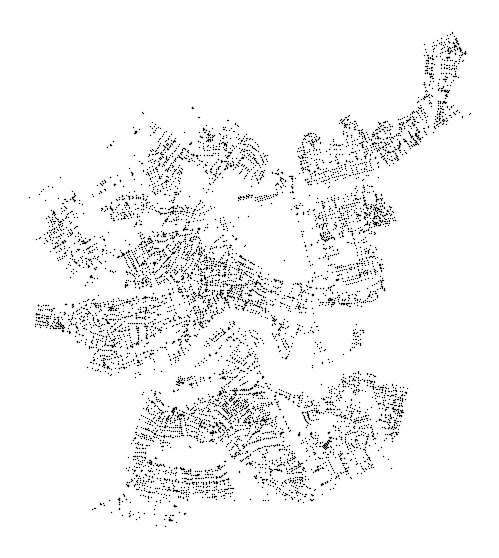

In [14]:
ax = geo_points.plot(figsize=(10,10), legend=True, color="k", markersize=0.3)
#ax.set_title(f"Street network nodes in {city} area")
_ = ax.axis("off")
plt.savefig(path_img_street_network_points, bbox_inches="tight", pad_inches=0)

Removing nodes that are not covered by district/neighborhood areas.

In [15]:
import sys
import logging
logging.basicConfig(level=logging.INFO)

# Network module includes the "clean_network" function
# to get the largest strongly connected graph.

import network as nw

try:
    print(f"Loading graph '{network_path}'.")
    G = ox.load_graphml(network_path, folder=folder)
    geo_points = gpd.read_file(path_city_geopoints)

except Exception as e:
    print(f"Cannot load data! Exception: '{e}'")
    G = copy.deepcopy(G_original)
    print("# Original graph:")
    print(nw.get_graph_info(G))

    print(f"\n# Removing nodes:")
    nodes_to_remove = set(G.nodes) - set(geo_points["id"])
    G.remove_nodes_from(nodes_to_remove)
    print("Nodes to remove:", len(nodes_to_remove))
    print(nw.get_graph_info(G))

    print("\n# Cleaning network:")
    G_cleaned = nw.clean_network(G)
    print(nw.get_graph_info(G_cleaned))
    removed = set(G.nodes) - set(G_cleaned)
    print(f"Removed: {len(removed)}.")

    print("\n# After relabel:")
    mapping = {k: i for i, k in enumerate(sorted(G_cleaned.nodes))}
    G = nx.relabel_nodes(G_cleaned, mapping)
    
    # Remove exlcluded points
    geo_points = geo_points[~geo_points["id"].isin(removed)].copy()
    geo_points["id"] = geo_points["id"].apply(lambda row: mapping[row])
    geo_points.sort_values(by="id", inplace=True)
    
    # Save points
    geo_points.to_file(path_city_geopoints)
    
    # Save graphs
    ox.save_graphml(G, filename=network_path, folder=folder)

print(nw.get_graph_info(G))
geo_points

Loading graph 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/rotterdam-the-netherlands.graphml'.
Cannot load data! Exception: '[Errno 2] No such file or directory: 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/rotterdam-the-netherlands.graphml''
# Original graph:
#NODES: 11245 (26673101 -> 7706832370) -- #EDGES: 25387

# Removing nodes:
Nodes to remove: 675
#NODES: 10570 (26673101 -> 7706832370) -- #EDGES: 23856

# Cleaning network:
#NODES: 10360 (26673101 -> 7706832370) -- #EDGES: 23045
Removed: 210.

# After relabel:
#NODES: 10360 (0 -> 10359) -- #EDGES: 23045


INFO:root:Size of strongly connected components: [10360, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


,id,lon,lat,geometry,WK_NAAM,BU_NAAM
11219,0,4.556128,51.888559,POINT (97787.504 433664.037),IJsselmonde,Groot IJsselmonde
2916,1,4.556644,51.890392,POINT (97825.321 433867.565),IJsselmonde,Groot IJsselmonde
2920,2,4.554555,51.890036,POINT (97681.068 433829.660),IJsselmonde,Groot IJsselmonde
2927,3,4.553470,51.889854,POINT (97606.182 433810.268),IJsselmonde,Groot IJsselmonde
4751,4,4.426126,51.915170,POINT (88877.413 436734.894),Delfshaven,Witte Dorp
...,...,...,...,...,...,...
9619,10355,4.541026,51.883727,POINT (96741.627 433138.489),IJsselmonde,Groot IJsselmonde
9620,10356,4.541191,51.883264,POINT (96752.353 433086.837),IJsselmonde,Groot IJsselmonde
9621,10357,4.540741,51.883568,POINT (96721.814 433121.017),IJsselmonde,Groot IJsselmonde
9622,10358,4.540908,51.883103,POINT (96732.661 433069.186),IJsselmonde,Groot IJsselmonde


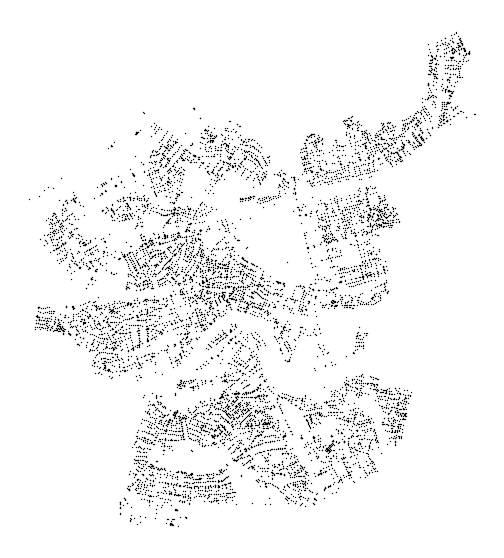

In [16]:
ax = geo_points.plot(figsize=(10,10), legend=True, color="k", markersize=0.3)
#ax.set_title(f"Street network nodes in {city} area")
_ = ax.axis("off")
plt.savefig(path_img_street_network_points_cleaned, bbox_inches="tight", pad_inches=0)

### Creating the distance matrix

Get the shortest path between all nodes in graph:


In [17]:
distance_matrix_m = nw.get_distance_dic(path_dist_matrix_npy, G)

print("Loaded distance matrix:", type(distance_matrix_m), distance_matrix_m.shape)

Creating distance matrix...
Loaded distance matrix: <class 'numpy.ndarray'> (10360, 10360)


INFO:root:
Trying to read distance matrix from file:
'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/distance_matrix_m.npy'.
INFO:root:Reading failed! Exception: [Errno 2] No such file or directory: 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/notebooks/output/rotterdam/distance_matrix_m.npy' 
Calculating shortest paths...
INFO:root:Distance data loaded successfully.  #Nodes: (10360, 10360)


In [18]:
geo_points

,id,lon,lat,geometry,WK_NAAM,BU_NAAM
11219,0,4.556128,51.888559,POINT (97787.504 433664.037),IJsselmonde,Groot IJsselmonde
2916,1,4.556644,51.890392,POINT (97825.321 433867.565),IJsselmonde,Groot IJsselmonde
2920,2,4.554555,51.890036,POINT (97681.068 433829.660),IJsselmonde,Groot IJsselmonde
2927,3,4.553470,51.889854,POINT (97606.182 433810.268),IJsselmonde,Groot IJsselmonde
4751,4,4.426126,51.915170,POINT (88877.413 436734.894),Delfshaven,Witte Dorp
...,...,...,...,...,...,...
9619,10355,4.541026,51.883727,POINT (96741.627 433138.489),IJsselmonde,Groot IJsselmonde
9620,10356,4.541191,51.883264,POINT (96752.353 433086.837),IJsselmonde,Groot IJsselmonde
9621,10357,4.540741,51.883568,POINT (96721.814 433121.017),IJsselmonde,Groot IJsselmonde
9622,10358,4.540908,51.883103,POINT (96732.661 433069.186),IJsselmonde,Groot IJsselmonde


In [19]:
# ##### CRS (Coordinate Reference System)
#  4326 = WGS 84 - WGS84 - World Geodetic System 1984, used in GPS
# 28992 = Amersfoort / RD New -- Netherlands - Holland - Dutch

# Project graph using CRS of Dutch data
G_proj = ox.project_graph(G, to_crs=('EPSG:28992'))

In [20]:
# Plot projection
fig, ax = ox.plot_graph(
    G_proj,
    fig_height=10,
    fig_width=20,
    node_color="#C0C0C0",
    node_size=1,
    edge_linewidth=0.5,
    node_zorder=0,
    edge_color="#D3D3D3",
    show=False,
    close=False,
)#, node_edgecolor='k', edge_color='#777777')
plt.close()

Plotting neighborhoods and annotations:

Plot district boundaries over street network:

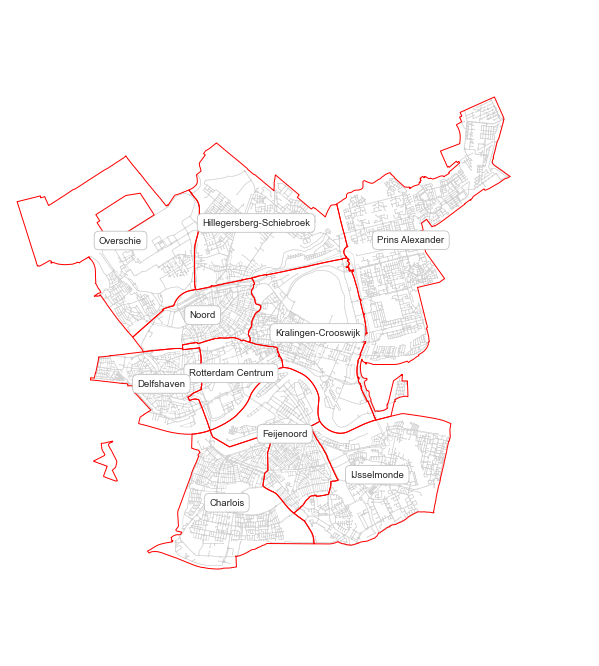

<Figure size 432x288 with 0 Axes>

In [21]:
sns.set_context("paper")
sns.set_style("white")

# Plot street network projection
fig_snet, ax_snet = ox.plot_graph(
    G_proj,
    fig_height=12,
    margin=0.2,
    node_color="#C0C0C0",
    node_size=1,
    edge_linewidth=0.5,
    node_zorder=0,
    edge_color="#D3D3D3",
    show=False,
    close=False,
)#, node_edgecolor='k', edge_color='#777777')
plt.close()

# Plot district boundaries
wijk_shp.geometry.boundary.plot(ax=ax_snet, color='red', linewidth=1,zorder=100)

# Annotate district names
_ = wijk_shp.apply(
        lambda x: ax_snet.annotate(
            s=x.WK_NAAM,
            xy=x.geometry.centroid.coords[0],
            ha='center',
            bbox=dict(
                facecolor='white',
                edgecolor='silver',
                boxstyle='round,pad=0.5'
            ),
            zorder=200,
        ),
        axis=1
    )

fig_snet.savefig(path_img_street_network_neighbors) #, bbox_inches="tight", pad_inches=0)
fig_snet

## Creating hexbins to aggregate nodes

Using  [H3](https://eng.uber.com/h3/) grid system, Uber’s hexagonal hierarchical spatial index.

Table of Cell Areas for H3 Resolutions ([link](https://h3geo.org/#/documentation/core-library/resolution-table)):

Resolutions used:

|H3 <br>Resolution | Average Hexagon<br>Area (km2) | Average Hexagon<br>Edge Length (km)|
|:-------------:|:---------------------------:|:--------------------------------:|
|6|6.1290521|3.229482772|
|7|5.1612932|1.220629759|
|8|0.7373276|0.461354684|
|9|0.1053325|0.174375668|
|10|0.0150475|0.065907807|
|11|0.0021496|0.024910561|

In [22]:
from h3 import h3
def hex_geo(lat, lon, res):
    """Return hexbin id and geometries of hexagon covering (lon, lat) at resoluton res"""
    # Get the index
    h = h3.geo_to_h3(lat=lat,lng=lon, res=res)
    
    # Find the geographic boundariy [[coord1], [coord2], ...,[coord6]]
    geo = h3.h3_to_geo_boundary(h3_address=h)
    
    # Create polygon (invert lat/lon)
    poly = Polygon([[c[1], c[0]] for c in geo])

    # Lon, lat coordinates of hexagon centroid
    centroid = poly.centroid
    
    # Find in G the nearest intersection to the centroid
    node_id = ox.get_nearest_node(G, (centroid.y, centroid.x), return_dist=False)
    
    # Get the (lon, lat) of the node
    node_gps = Point(G.nodes[node_id]["x"], G.nodes[node_id]["y"])

    return (h, poly, centroid, node_id, node_gps)

# Dataframe with the hexbin info
geo_points_hex = copy.deepcopy(geo_points)
geo_points_hex = geo_points_hex.to_crs('EPSG:4326')

# H3 supports sixteen resolutions. Each finer resolution has cells with one seventh 
# the area of the coarser resolution. Hexagons cannot be perfectly subdivided into 
# seven hexagons, so the finer cells are only approximately contained within a parent cell.
hex_res = [9, 8, 7]
for i, res in enumerate(hex_res):
    geo_points_hex[
        [
            f"hex_{res:02}",
            f"geo_{res:02}",
            f"centroid_{res:02}",
            f"centroid_node_{res:02}",
            f"centroid_node_gps_{res:02}"
        ]
    ] = geo_points.apply(
            lambda row: hex_geo(
                row.lat,
                row.lon,
                res=res
            ),
            axis=1,
            result_type='expand'
    )

In [23]:
geo_points_hex = geo_points_hex.dropna()
geo_points_hex.sort_values(by=["id", "hex_07", "hex_08", "hex_09"], inplace=True)
geo_points_hex[[
    "id", "lon", "lat", "WK_NAAM", "BU_NAAM",
    "hex_07", "hex_08", "hex_09",
    "centroid_07", "centroid_08", "centroid_09",
    "centroid_node_07", "centroid_node_08", "centroid_node_09",]
].rename(columns={"WK_NAAM":"district", "BU_NAAM":"neighborhood"}).to_csv(path_node_hex, index=False)

geo_points_hex

,id,lon,lat,geometry,WK_NAAM,BU_NAAM,hex_09,geo_09,centroid_09,centroid_node_09,...,hex_08,geo_08,centroid_08,centroid_node_08,centroid_node_gps_08,hex_07,geo_07,centroid_07,centroid_node_07,centroid_node_gps_07
11219,0,4.556128,51.888559,POINT (4.55613 51.88856),IJsselmonde,Groot IJsselmonde,89196bb5c8bffff,"POLYGON ((4.551200299491461 51.8890517784516, ...",POINT (4.553725172435525 51.88858295360058),1271,...,88196bb5c9fffff,"POLYGON ((4.553071522540672 51.89177826684732,...",POINT (4.558448346307102 51.88924278016209),1354,POINT (4.5581365 51.8894494),87196bb5cffffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.54998416339768 51.88312893419094),838,POINT (4.550623 51.8830696)
2916,1,4.556644,51.890392,POINT (4.55664 51.89039),IJsselmonde,Groot IJsselmonde,89196bb5c9bffff,"POLYGON ((4.553071522540672 51.89177826684732,...",POINT (4.555596517899619 51.89130944074267),1597,...,88196bb5c9fffff,"POLYGON ((4.553071522540672 51.89177826684732,...",POINT (4.558448346307102 51.88924278016209),1354,POINT (4.5581365 51.8894494),87196bb5cffffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.54998416339768 51.88312893419094),838,POINT (4.550623 51.8830696)
2920,2,4.554555,51.890036,POINT (4.55455 51.89004),IJsselmonde,Groot IJsselmonde,89196bb5c9bffff,"POLYGON ((4.553071522540672 51.89177826684732,...",POINT (4.555596517899619 51.89130944074267),1597,...,88196bb5c9fffff,"POLYGON ((4.553071522540672 51.89177826684732,...",POINT (4.558448346307102 51.88924278016209),1354,POINT (4.5581365 51.8894494),87196bb5cffffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.54998416339768 51.88312893419094),838,POINT (4.550623 51.8830696)
2927,3,4.553470,51.889854,POINT (4.55347 51.88985),IJsselmonde,Groot IJsselmonde,89196bb5c8bffff,"POLYGON ((4.551200299491461 51.8890517784516, ...",POINT (4.553725172435525 51.88858295360058),1271,...,88196bb5c9fffff,"POLYGON ((4.553071522540672 51.89177826684732,...",POINT (4.558448346307102 51.88924278016209),1354,POINT (4.5581365 51.8894494),87196bb5cffffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.54998416339768 51.88312893419094),838,POINT (4.550623 51.8830696)
4751,4,4.426126,51.915170,POINT (4.42613 51.91517),Delfshaven,Witte Dorp,89196ba2007ffff,"POLYGON ((4.424308306187035 51.9156011514897, ...",POINT (4.42683290041553 51.91513565024714),2925,...,88196ba201fffff,"POLYGON ((4.418599424433451 51.91972366681556,...",POINT (4.423978714144117 51.91719699827949),3040,POINT (4.4242957 51.9170059),87196ba20ffffff,"POLYGON ((4.406306381300341 51.92045345841772,...",POINT (4.423979726344801 51.91719635376327),3040,POINT (4.4242957 51.9170059)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,10355,4.541026,51.883727,POINT (4.54103 51.88373),IJsselmonde,Groot IJsselmonde,89196bb5c57ffff,"POLYGON ((4.539884618505602 51.88500452466931,...",POINT (4.542409223688013 51.88453589796229),7878,...,88196bb5c5fffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.537687344981484 51.88387531134873),876,POINT (4.5381674 51.8837275),87196bb5cffffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.54998416339768 51.88312893419094),838,POINT (4.550623 51.8830696)
9620,10356,4.541191,51.883264,POINT (4.54119 51.88326),IJsselmonde,Groot IJsselmonde,89196bb5c57ffff,"POLYGON ((4.539884618505602 51.88500452466931,...",POINT (4.542409223688013 51.88453589796229),7878,...,88196bb5c5fffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.537687344981484 51.88387531134873),876,POINT (4.5381674 51.8837275),87196bb5cffffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.54998416339768 51.88312893419094),838,POINT (4.550623 51.8830696)
9621,10357,4.540741,51.883568,POINT (4.54074 51.88357),IJsselmonde,Groot IJsselmonde,89196bb5c57ffff,"POLYGON ((4.539884618505602 51.88500452466931,...",POINT (4.542409223688013 51.88453589796229),7878,...,88196bb5c5fffff,"POLYGON ((4.532310920941071 51.88640996

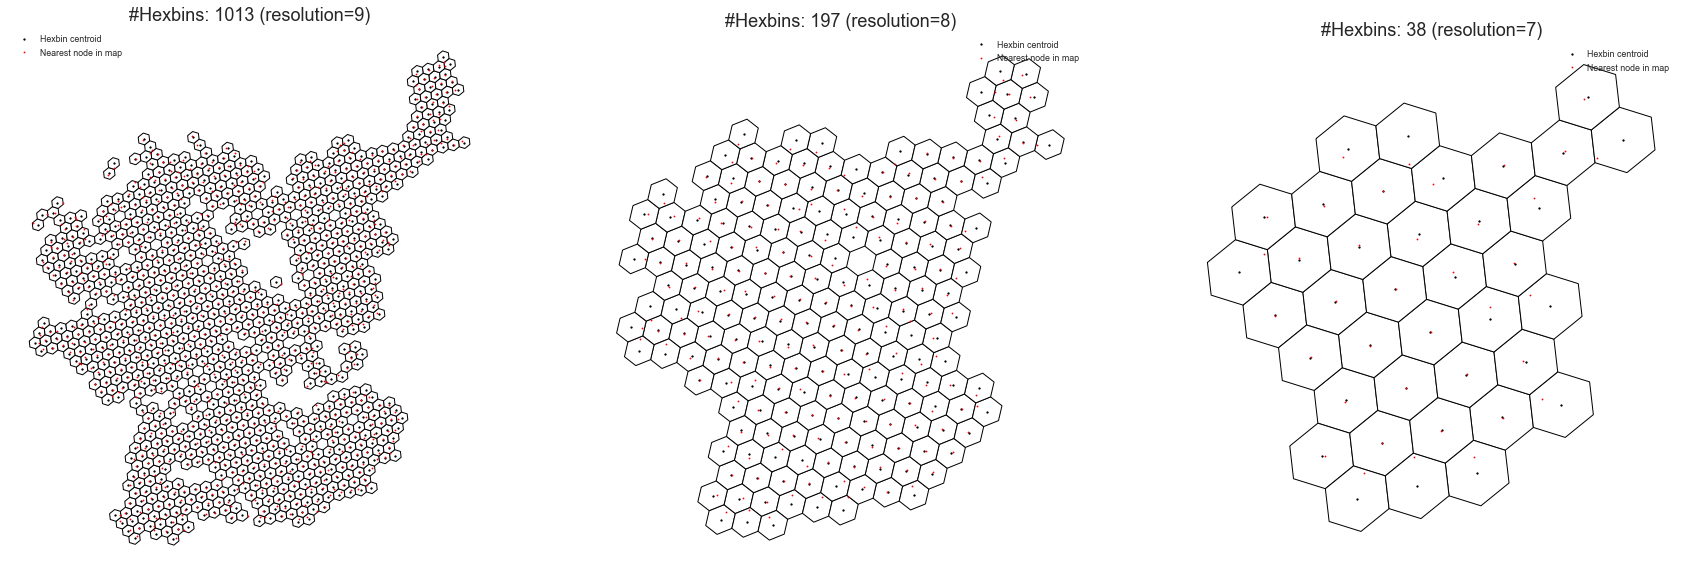

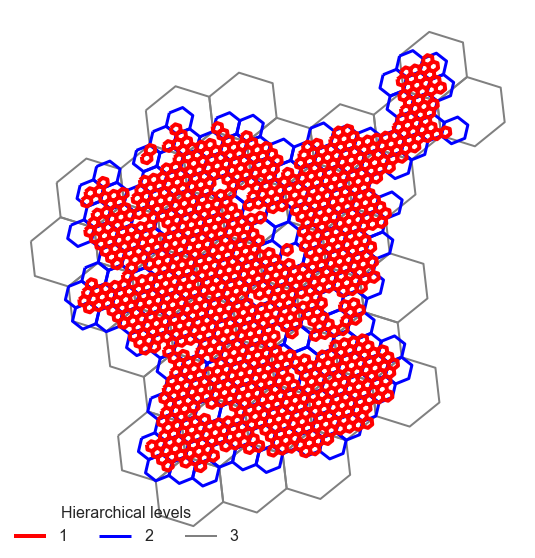

In [24]:
sns.set_context("paper")
sns.set_style("white")

color_levels = ["r", "b", "gray"]
legend_levels = ["1", "2", "3"]
fig, ax = plt.subplots(1, len(hex_res), figsize=(len(hex_res)*10, 10))
fig_overlay, ax_overlay = plt.subplots(1, 1, figsize=(10, 10))

for i, res in enumerate(hex_res):

    # Isolate elements of a single resolution and drop duplicates
    geo_hex = geo_points_hex.drop_duplicates(f"hex_{res:02}")[[f"hex_{res:02}", f"geo_{res:02}", f"centroid_{res:02}", f"centroid_node_{res:02}", f"centroid_node_gps_{res:02}"]]

    # Create geodf for hexagons
    geo_hex_df = gpd.GeoDataFrame(geo_hex[f"hex_{res:02}"], geometry=geo_hex[f"geo_{res:02}"])
    geo_hex_df.crs = 'EPSG:4326'
    
    # Create geodf for the centroid
    geo_centroid_df = gpd.GeoDataFrame(geo_hex[f"centroid_{res:02}"], geometry=geo_hex[f"centroid_{res:02}"])
    geo_centroid_df.crs = 'EPSG:4326'

    # Create geodf for the closest network node from centroid
    geo_centroid_node_df = gpd.GeoDataFrame(geo_hex[f"centroid_node_gps_{res:02}"], geometry=geo_hex[f"centroid_node_gps_{res:02}"])
    geo_centroid_node_df.crs = 'EPSG:4326'

    geo_hex_df.to_crs('EPSG:28992').plot(ax=ax[i], color='white', edgecolor='black', linewidth=1)
    geo_hex_df.boundary.to_crs('EPSG:28992').plot(ax=ax_overlay, color=color_levels[i], label=legend_levels[i], linewidth=1+len(legend_levels)-i, zorder=len(legend_levels)-i)
    
    geo_centroid_df.to_crs('EPSG:28992').plot(ax=ax[i], color="black", markersize=2, label="Hexbin centroid")
    geo_centroid_node_df.to_crs('EPSG:28992').plot(ax=ax[i], color="red", markersize=1, label="Nearest node in map")
    n_hex = len(geo_hex[f"hex_{res:02}"])
    ax[i].set_title(f"#Hexbins: {n_hex} (resolution={res})", size=18)
    ax[i].legend(frameon=False, loc="best")
    ax[i].axis("off")

fig.savefig(path_hexbins, bbox_inches='tight', pad_inches=0)
ax_overlay.legend(frameon=False, loc=(0,0), title="Hierarchical levels", fontsize=16, title_fontsize=16, ncol=len(hex_res))
ax_overlay.axis("off")
fig_overlay.savefig(path_overlay_hexbins, bbox_inches="tight", pad_inches=0)

plt.show()

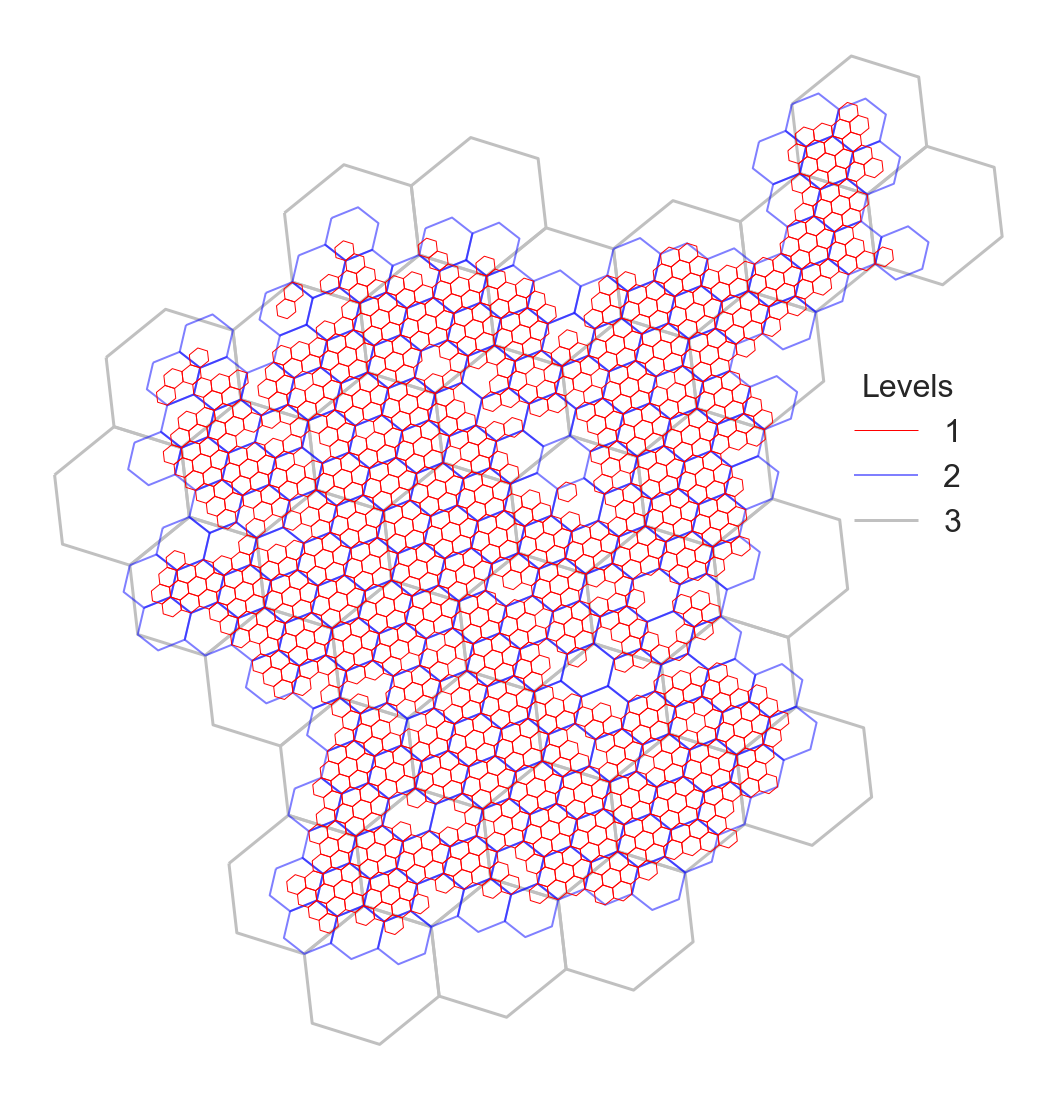

In [25]:
sns.set_context("paper")
sns.set_style("white")

color_levels = ["r", "b", "#C0C0C0"]
legend_levels = ["1", "2", "3"]
alpha_levels = [1, 0.5, 1]
linewidth_levels = [1,2,3]
fig_overlay, ax_overlay = plt.subplots(1, 1, figsize=(20, 20))

for i, res in enumerate(hex_res):

    # Isolate elements of a single resolution and drop duplicates
    geo_hex = geo_points_hex.drop_duplicates(f"hex_{res:02}")[[f"hex_{res:02}", f"geo_{res:02}", f"centroid_{res:02}", f"centroid_node_{res:02}", f"centroid_node_gps_{res:02}"]]

    # Create geodf for hexagons
    geo_hex_df = gpd.GeoDataFrame(geo_hex[f"hex_{res:02}"], geometry=geo_hex[f"geo_{res:02}"])
    geo_hex_df.crs = 'EPSG:4326'
    geo_hex_df.boundary.to_crs('EPSG:28992').plot(
        ax=ax_overlay,
        color=color_levels[i],
        label=legend_levels[i],
        alpha=alpha_levels[i],
        linewidth=linewidth_levels[i],
        zorder=len(legend_levels)-i
    )

ax_overlay.legend(
    frameon=False,
    loc=(0.8,1/2),
    title="Levels",
    fontsize=32,
    title_fontsize=32,
    #ncol=len(hex_res)
)

ax_overlay.axis("off")
fig_overlay.savefig(path_overlay_hexbins, bbox_inches="tight", pad_inches=0)

plt.show()

# Merging income statistical data

In [26]:
df_nl_stats = pd.read_csv(path_stats)

col_rename = {
    "GemiddeldInkomenPerInkomensontvanger_65":"avg_income_per_income_receiver",
    "k_40PersonenMetLaagsteInkomen_67":"people_lowest_income",
    "HuishOnderOfRondSociaalMinimum_73":"house_under_social_minimum",
    "GemiddeldInkomenPerInwoner_66":"avg_income_per_people",
}
# Change column name for join
df_nl_stats = df_nl_stats.rename(columns=col_rename)


df_nl_stats_buurt = df_nl_stats.rename(columns={"WijkenEnBuurten":"BU_CODE"})
df_nl_stats_buurt = df_nl_stats_buurt[df_nl_stats_buurt['SoortRegio_2'].apply(lambda row:row.strip())=="Buurt"]

df_nl_stats_wijk = df_nl_stats.rename(columns={"WijkenEnBuurten":"WK_CODE"})
df_nl_stats_wijk = df_nl_stats_wijk[df_nl_stats_wijk['SoortRegio_2'].apply(lambda row:row.strip())=="Wijk"]

df_nl_stats_wijk = df_nl_stats_wijk[list(col_rename.values())+["WK_CODE"]]
df_nl_stats_buurt = df_nl_stats_buurt[list(col_rename.values())+["BU_CODE"]]

# Remove invalid whitespaces
for col in list(col_rename.values())+["WK_CODE"]:
    df_nl_stats_wijk[col] = df_nl_stats_wijk[col].apply(lambda row:row.strip())
    df_nl_stats_wijk = df_nl_stats_wijk[df_nl_stats_wijk[col]!="."]

for col in list(col_rename.values())+["BU_CODE"]:
    df_nl_stats_buurt[col] = df_nl_stats_buurt[col].apply(lambda row:row.strip())
    df_nl_stats_buurt = df_nl_stats_buurt[df_nl_stats_buurt[col]!="."]

In [27]:
df_nl_stats

,ID,WijkenEnBuurten,Gemeentenaam_1,SoortRegio_2,Codering_3,IndelingswijzigingWijkenEnBuurten_4,AantalInwoners_5,Mannen_6,Vrouwen_7,k_0Tot15Jaar_8,...,OppervlakteTotaal_99,OppervlakteLand_100,OppervlakteWater_101,MeestVoorkomendePostcode_102,Dekkingspercentage_103,MateVanStedelijkheid_104,Omgevingsadressendichtheid_105,TotaalDiefstalUitWoningSchuurED_106,VernielingMisdrijfTegenOpenbareOrde_107,GeweldsEnSeksueleMisdrijven_108
0,12312,GM0599,Rotterdam,Gemeente,GM0599,.,634660,312781,321879,103435,...,32416,21564,10852,.,.,1,3932,5,6,9
1,12313,WK059901,Rotterdam,Wijk,WK059901,1,33995,17670,16325,3170,...,488,414,74,.,.,1,6110,4,12,29
2,12314,BU05990110,Rotterdam,Buurt,BU05990110,1,15615,8175,7435,1240,...,173,136,37,3011,1,1,6287,4,11,19
3,12315,BU05990111,Rotterdam,Buurt,BU05990111,1,9435,4790,4640,1290,...,57,57,0,3014,2,1,6290,4,6,13
4,12316,BU05990112,Rotterdam,Buurt,BU05990112,1,5660,2915,2740,435,...,61,61,0,3012,1,1,6186,4,21,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,12422,WK059926,Rotterdam,Wijk,WK059926,1,0,0,0,0,...,152,152,0,.,.,5,34,NaN,NaN,NaN
111,12423,BU05992650,Rotterdam,Buurt,BU05992650,1,0,0,0,0,...,152,152,0,3046,1,5,34,NaN,NaN,NaN
112,12424,WK059927,Rotterdam,Wijk,WK059927,1,12365,6110,6255,1940,...,650,452,198,.,.,3,1203,3,4,6
113,12425,BU05992704,Rotterdam,Buurt,BU05992704,1,12365,6110,6255,1940,...,411,325,86,3181,1,3,1203,3,4,6


In [28]:
df_nl_stats[df_nl_stats["Gemeentenaam_1"]=="Rijswijk"]

,ID,WijkenEnBuurten,Gemeentenaam_1,SoortRegio_2,Codering_3,IndelingswijzigingWijkenEnBuurten_4,AantalInwoners_5,Mannen_6,Vrouwen_7,k_0Tot15Jaar_8,...,OppervlakteTotaal_99,OppervlakteLand_100,OppervlakteWater_101,MeestVoorkomendePostcode_102,Dekkingspercentage_103,MateVanStedelijkheid_104,Omgevingsadressendichtheid_105,TotaalDiefstalUitWoningSchuurED_106,VernielingMisdrijfTegenOpenbareOrde_107,GeweldsEnSeksueleMisdrijven_108


In [29]:
df_nl_stats_wijk

,avg_income_per_income_receiver,people_lowest_income,house_under_social_minimum,avg_income_per_people,WK_CODE
1,37.3,38.9,12.7,32.1,WK059901
8,25.2,52.1,19.3,19.7,WK059903
18,31.8,40.8,11.9,24.6,WK059904
25,29.8,42.9,14.4,24.5,WK059905
33,43,36.1,9.8,32.5,WK059906
39,32.8,47.7,16.4,26.5,WK059908
48,25.1,53.8,21,19.2,WK059910
58,26.5,45.4,13.5,20.7,WK059912
63,31.1,36.3,4.7,25.1,WK059913
65,32.8,40,11,26.1,WK059914


In [30]:
wijk_shp

,GM_NAAM,WK_CODE,WK_NAAM,AANT_INW,geometry,share_residents
1462,Rotterdam,WK059901,Rotterdam Centrum,35050,"POLYGON ((91412.788 437507.740, 91406.180 4375...",0.060269
1463,Rotterdam,WK059903,Delfshaven,76215,"POLYGON ((89158.883 436492.503, 89145.772 4364...",0.131053
1464,Rotterdam,WK059904,Overschie,18840,"POLYGON ((87962.448 440438.639, 87890.050 4403...",0.032396
1465,Rotterdam,WK059905,Noord,52025,"POLYGON ((91300.683 439410.347, 91757.468 4395...",0.089458
1466,Rotterdam,WK059906,Hillegersberg-Schiebroek,44475,"POLYGON ((91239.000 440237.689, 91239.000 4402...",0.076475
1467,Rotterdam,WK059908,Kralingen-Crooswijk,54215,"POLYGON ((93015.124 438345.351, 93014.008 4383...",0.093223
1468,Rotterdam,WK059910,Feijenoord,75530,"POLYGON ((92994.584 436176.174, 93001.000 4361...",0.129875
1469,Rotterdam,WK059912,IJsselmonde,60840,"POLYGON ((95433.522 434054.706, 95413.068 4340...",0.104615
1471,Rotterdam,WK059914,Prins Alexander,95775,"POLYGON ((96393.260 439120.118, 96381.741 4391...",0.164686
1472,Rotterdam,WK059915,Charlois,68595,"MULTIPOLYGON (((88818.532 434027.283, 88812.37...",0.117950


### Merging stats to districts

In [31]:
#color_column = "house_under_social_minimum"
#color_column = "people_lowest_income"
color_column = "avg_income_per_people"
title = {"avg_income_per_people":"Avg. income"}
wijk_shp_stats = pd.merge(wijk_shp, df_nl_stats_wijk, how="left", on="WK_CODE")
wijk_shp_stats = wijk_shp_stats.astype({
    "avg_income_per_income_receiver":float,
    "people_lowest_income":float,
    "house_under_social_minimum":float,
    "avg_income_per_people":float
})

wijk_shp_stats

,GM_NAAM,WK_CODE,WK_NAAM,AANT_INW,geometry,share_residents,avg_income_per_income_receiver,people_lowest_income,house_under_social_minimum,avg_income_per_people
0,Rotterdam,WK059901,Rotterdam Centrum,35050,"POLYGON ((91412.788 437507.740, 91406.180 4375...",0.060269,37.3,38.9,12.7,32.1
1,Rotterdam,WK059903,Delfshaven,76215,"POLYGON ((89158.883 436492.503, 89145.772 4364...",0.131053,25.2,52.1,19.3,19.7
2,Rotterdam,WK059904,Overschie,18840,"POLYGON ((87962.448 440438.639, 87890.050 4403...",0.032396,31.8,40.8,11.9,24.6
3,Rotterdam,WK059905,Noord,52025,"POLYGON ((91300.683 439410.347, 91757.468 4395...",0.089458,29.8,42.9,14.4,24.5
4,Rotterdam,WK059906,Hillegersberg-Schiebroek,44475,"POLYGON ((91239.000 440237.689, 91239.000 4402...",0.076475,43.0,36.1,9.8,32.5
5,Rotterdam,WK059908,Kralingen-Crooswijk,54215,"POLYGON ((93015.124 438345.351, 93014.008 4383...",0.093223,32.8,47.7,16.4,26.5
6,Rotterdam,WK059910,Feijenoord,75530,"POLYGON ((92994.584 436176.174, 93001.000 4361...",0.129875,25.1,53.8,21.0,19.2
7,Rotterdam,WK059912,IJsselmonde,60840,"POLYGON ((95433.522 434054.706, 95413.068 4340...",0.104615,26.5,45.4,13.5,20.7
8,Rotterdam,WK059914,Prins Alexander,95775,"POLYGON ((96393.260 439120.118, 96381.741 4391...",0.164686,32.8,40.0,11.0,26.1
9,Rotterdam,WK059915,Charlois,68595,"MULTIPOLYGON (((88818.532 434027.283, 88812.37...",0.117950,24.0,49.4,16.5,18.6


(84965.91811999958, 101797.67548000162, 430009.3362449985, 446129.258855002)

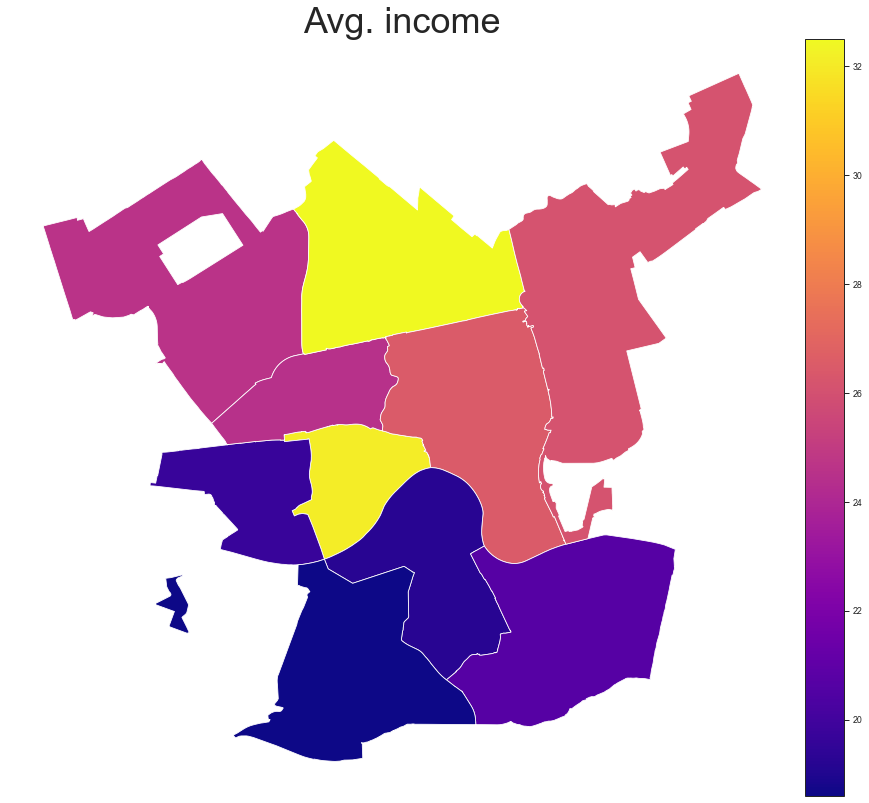

In [32]:
# Convert to geopandas again after changing types
wijk_shp_stats = gpd.GeoDataFrame(wijk_shp_stats)
fig, ax = plt.subplots(1,1,figsize=(15,15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
wijk_shp_stats.plot(column=color_column, cmap="plasma", ax=ax, legend=True, cax=cax)
ax.set_title(f"{title[color_column]}", fontsize=36)
ax.axis("off")

In [33]:
buurt_shp

,GM_NAAM,WK_NAAM,BU_CODE,BU_NAAM,AANT_INW,geometry,share_residents
6718,Rotterdam,Rotterdam Centrum,BU05990110,Stadsdriehoek,16390,"POLYGON ((92349.580 437925.056, 92375.713 4379...",0.028280
6719,Rotterdam,Rotterdam Centrum,BU05990111,Oude Westen,9445,"POLYGON ((91412.788 437507.740, 91415.880 4375...",0.016297
6720,Rotterdam,Rotterdam Centrum,BU05990112,Cool,5735,"POLYGON ((91925.500 437499.710, 91933.681 4375...",0.009896
6721,Rotterdam,Rotterdam Centrum,BU05990113,Cs Kwartier,1020,"POLYGON ((92326.078 437923.110, 92329.379 4379...",0.001760
6722,Rotterdam,Rotterdam Centrum,BU05990118,Nieuwe Werk,1755,"POLYGON ((92366.606 436291.783, 92369.250 4362...",0.003028
...,...,...,...,...,...,...,...
6785,Rotterdam,Charlois,BU05991574,Oud Charlois,13760,"POLYGON ((91162.000 434931.000, 91176.872 4349...",0.023742
6786,Rotterdam,Charlois,BU05991575,Wielewaal,420,"POLYGON ((91205.945 433249.497, 91227.890 4332...",0.000725
6787,Rotterdam,Charlois,BU05991576,Zuidplein,1265,"POLYGON ((93046.460 433834.390, 93049.450 4338...",0.002183
6788,Rotterdam,Charlois,BU05991577,Pendrecht,12390,"POLYGON ((90875.580 431872.570, 90940.980 4319...",0.021378


### Merging stats to neighborhoods

In [34]:
buurt_shp_stats = pd.merge(buurt_shp, df_nl_stats_buurt, how="left", on="BU_CODE")

buurt_shp_stats = buurt_shp_stats.astype({
    "avg_income_per_income_receiver":float,
    "people_lowest_income":float,
    "house_under_social_minimum":float,
    "avg_income_per_people":float
})
buurt_shp_stats

,GM_NAAM,WK_NAAM,BU_CODE,BU_NAAM,AANT_INW,geometry,share_residents,avg_income_per_income_receiver,people_lowest_income,house_under_social_minimum,avg_income_per_people
0,Rotterdam,Rotterdam Centrum,BU05990110,Stadsdriehoek,16390,"POLYGON ((92349.580 437925.056, 92375.713 4379...",0.028280,42.5,29.9,7.6,37.4
1,Rotterdam,Rotterdam Centrum,BU05990111,Oude Westen,9445,"POLYGON ((91412.788 437507.740, 91415.880 4375...",0.016297,25.4,56.7,24.9,20.7
2,Rotterdam,Rotterdam Centrum,BU05990112,Cool,5735,"POLYGON ((91925.500 437499.710, 91933.681 4375...",0.009896,36.7,35.6,12.5,32.2
3,Rotterdam,Rotterdam Centrum,BU05990113,Cs Kwartier,1020,"POLYGON ((92326.078 437923.110, 92329.379 4379...",0.001760,47.1,26.1,3.8,40.6
4,Rotterdam,Rotterdam Centrum,BU05990118,Nieuwe Werk,1755,"POLYGON ((92366.606 436291.783, 92369.250 4362...",0.003028,52.0,41.0,6.1,46.0
...,...,...,...,...,...,...,...,...,...,...,...
64,Rotterdam,Charlois,BU05991574,Oud Charlois,13760,"POLYGON ((91162.000 434931.000, 91176.872 4349...",0.023742,24.6,48.9,16.0,19.2
65,Rotterdam,Charlois,BU05991575,Wielewaal,420,"POLYGON ((91205.945 433249.497, 91227.890 4332...",0.000725,21.2,56.6,22.1,17.0
66,Rotterdam,Charlois,BU05991576,Zuidplein,1265,"POLYGON ((93046.460 433834.390, 93049.450 4338...",0.002183,30.1,35.1,9.5,25.8
67,Rotterdam,Charlois,BU05991577,Pendrecht,12390,"POLYGON ((90875.580 431872.570, 90940.980 4319...",0.021378,24.1,50.7,17.5,17.8


Text(0.5, 1.0, 'avg_income_per_people')

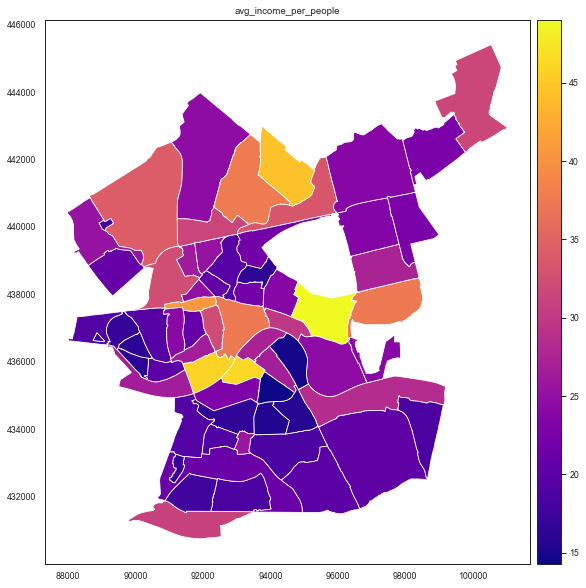

In [35]:
# Convert to geopandas again after changing types
buurt_shp_stats = gpd.GeoDataFrame(buurt_shp_stats)
fig, ax = plt.subplots(1,1,figsize=(10,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
buurt_shp_stats.plot(column=color_column, cmap="plasma", ax=ax, legend=True, cax=cax)
ax.set_title(f"{color_column}")

### Load bus stops

In [36]:
df_stops = pd.read_csv(path_stops)

# Select focus city
df_city = df_stops[df_stops["town"]==city]

print("Original with duplicated stations:")
df_city

Original with duplicated stations:


,id,operator_id,name,town,platformcode,latitude,longitude,rd_x,rd_y,isscheduled
43,50478,RET:HA6420,"Rotterdam, Zuidplein",Rotterdam,NaN,51.887566,4.488447,93127.0,433609.0,t
1002,2959,ARR:53240370,"Rotterdam, P+R Beverwaard",Rotterdam,NaN,51.886066,4.569836,98728.0,433376.0,t
1021,2978,ARR:53000030,"Rotterdam, Beurs",Rotterdam,NaN,51.919518,4.479900,92583.0,437171.0,t
1204,3159,ARR:53240310,"Rotterdam, Kreekhuizenlaan",Rotterdam,NaN,51.883878,4.538850,96592.0,433157.0,t
1220,3174,ARR:53240400,"Rotterdam, Molgerdijk",Rotterdam,NaN,51.873727,4.542294,96816.0,432025.0,t
...,...,...,...,...,...,...,...,...,...,...
52786,52373,RET:HA2704,"Rotterdam, Lorentzweg",Rotterdam,NaN,51.963560,4.534798,96417.0,442025.0,t
52787,52374,RET:HA2703,"Rotterdam, Lorentzweg",Rotterdam,NaN,51.963620,4.534389,96389.0,442032.0,t
52788,52375,RET:HA2702,"Rotterdam, Reuzel",Rotterdam,NaN,51.962229,4.568958,98763.0,441850.0,t
52789,52377,RET:HA2700,"Rotterdam, Port Saïdstraat",Rotterdam,NaN,51.946781,4.566840,98598.0,440133.0,t


In [37]:
df_city = df_city.drop_duplicates("name")
print("After dropping duplicate bus stops:")
df_city.sort_values(by="rd_x")

After dropping duplicate bus stops:


,id,operator_id,name,town,platformcode,latitude,longitude,rd_x,rd_y,isscheduled
33576,50703,RET:HA3225,"Rotterdam, Kiotoweg",Rotterdam,NaN,51.943198,4.397871,86976.0,439879.0,t
34154,52074,RET:HA3631,"Rotterdam, Hofwijk",Rotterdam,NaN,51.957217,4.398493,87040.0,441438.0,t
50642,50160,RET:HA2325,"Rotterdam, Singaporestraat",Rotterdam,NaN,51.944668,4.403875,87391.0,440037.0,t
51341,51548,RET:HA2401,"Rotterdam, Caïrostraat",Rotterdam,NaN,51.941455,4.404483,87428.0,439679.0,t
34155,52075,RET:HA3632,"Rotterdam, De Tempel",Rotterdam,NaN,51.952652,4.406188,87562.0,440923.0,t
...,...,...,...,...,...,...,...,...,...,...
8583,10543,ARR:54600380,"Rotterdam, Cesar Domelastraat",Rotterdam,NaN,51.980729,4.590077,100237.0,443892.0,t
8791,10758,ARR:54600350,"Rotterdam, Wout van Heusdensingel",Rotterdam,NaN,51.985002,4.590525,100273.0,444367.0,t
51459,51781,RET:HA2644,"Rotterdam, Wout van Heusdensing",Rotterdam,NaN,51.984959,4.590832,100294.0,444362.0,t
51038,50973,RET:HA6270,"Rotterdam, Randweg",Rotterdam,NaN,51.883134,4.597195,100608.0,433029.0,t


In [38]:
# Create list of points
geometry_stops = df_city.apply(lambda x:Point(x.longitude, x.latitude), axis=1)

# Create geopandas df
geo_stops = gpd.GeoDataFrame(df_city[["id", "name", "latitude", "longitude"]], geometry=geometry_stops)
geo_stops["name"] = geo_stops["name"].apply(
    lambda x: x.replace('Rotterdam, ','')
)

geo_stops.crs = ('EPSG:4326')
geo_stops.head(10)

,id,name,latitude,longitude,geometry
43,50478,Zuidplein,51.887566,4.488447,POINT (4.48845 51.88757)
1002,2959,P+R Beverwaard,51.886066,4.569836,POINT (4.56984 51.88607)
1021,2978,Beurs,51.919518,4.479900,POINT (4.47990 51.91952)
1204,3159,Kreekhuizenlaan,51.883878,4.538850,POINT (4.53885 51.88388)
1220,3174,Molgerdijk,51.873727,4.542294,POINT (4.54229 51.87373)
1259,3538,HES,51.915914,4.529059,POINT (4.52906 51.91591)
1313,3266,Klein Nieuwland,51.886077,4.544648,POINT (4.54465 51.88608)
1382,3337,Keizerswaard,51.885690,4.548417,POINT (4.54842 51.88569)
1507,3451,Station Lombardijen,51.880877,4.534128,POINT (4.53413 51.88088)
1516,3460,Stadionweg,51.894820,4.530566,POINT (4.53057 51.89482)


# Simulating demand

Pickup probability is based on the relative population of districts and neighborhoods.

Save districts:

In [39]:
wijk_shp2 = wijk_shp.to_crs('EPSG:4326')
wijk_shp2["AANT_INW_AVG"] = wijk_shp2["AANT_INW"]/sum(wijk_shp2["AANT_INW"])
wijk_shp2.sort_values(by=["WK_NAAM"], inplace=True)
wijk_shp2[[
    "WK_CODE", "WK_NAAM", "AANT_INW", "AANT_INW_AVG", "geometry"
]].rename(columns={
    "WK_CODE":"distr_code",
    "WK_NAAM":"distr_name",
    "AANT_INW":"n_resident",
    "AANT_INW_AVG":"mean_resid"}).to_file(path_shp_districts)
wijk_shp2

,GM_NAAM,WK_CODE,WK_NAAM,AANT_INW,geometry,share_residents,AANT_INW_AVG
1472,Rotterdam,WK059915,Charlois,68595,"MULTIPOLYGON (((4.42579 51.89083, 4.42571 51.8...",0.117950,0.117950
1463,Rotterdam,WK059903,Delfshaven,76215,"POLYGON ((4.43026 51.91303, 4.43007 51.91303, ...",0.131053,0.131053
1468,Rotterdam,WK059910,Feijenoord,75530,"POLYGON ((4.48606 51.91062, 4.48615 51.91074, ...",0.129875,0.129875
1466,Rotterdam,WK059906,Hillegersberg-Schiebroek,44475,"POLYGON ((4.45980 51.94693, 4.45979 51.94721, ...",0.076475,0.076475
1469,Rotterdam,WK059912,IJsselmonde,60840,"POLYGON ((4.52187 51.89182, 4.52157 51.89219, ...",0.104615,0.104615
1467,Rotterdam,WK059908,Kralingen-Crooswijk,54215,"POLYGON ((4.48597 51.93012, 4.48595 51.93041, ...",0.093223,0.093223
1465,Rotterdam,WK059905,Noord,52025,"POLYGON ((4.46085 51.93950, 4.46747 51.94041, ...",0.089458,0.089458
1464,Rotterdam,WK059904,Overschie,18840,"POLYGON ((4.41211 51.94835, 4.41106 51.94793, ...",0.032396,0.032396
1471,Rotterdam,WK059914,Prins Alexander,95775,"POLYGON ((4.53495 51.93745, 4.53478 51.93742, ...",0.164686,0.164686
1462,Rotterdam,WK059901,Rotterdam Centrum,35050,"POLYGON ((4.46283 51.92241, 4.46273 51.92276, ...",0.060269,0.060269


Save neighborhoods:

In [40]:
buurt_shp2 = buurt_shp.to_crs('EPSG:4326')
buurt_shp2["AANT_INW_AVG"] = buurt_shp2["AANT_INW"]/sum(buurt_shp2["AANT_INW"])
buurt_shp2.sort_values(by=["WK_NAAM"], inplace=True)
buurt_shp2[[
    "WK_NAAM", "BU_NAAM", "BU_CODE", "AANT_INW", "AANT_INW_AVG", "geometry"
]].rename(columns={
    "BU_CODE":"neigh_code",
    "WK_NAAM":"distr_name",
    "BU_NAAM":"neigh_name",
    "AANT_INW":"n_resident",
    "AANT_INW_AVG":"mean_resid"}).to_file(path_shp_neighborhoods)
buurt_shp2

,GM_NAAM,WK_NAAM,BU_CODE,BU_NAAM,AANT_INW,geometry,share_residents,AANT_INW_AVG
6789,Rotterdam,Charlois,BU05991578,Zuiderpark,1275,"POLYGON ((4.45780 51.88482, 4.45798 51.88478, ...",0.002200,0.002200
6788,Rotterdam,Charlois,BU05991577,Pendrecht,12390,"POLYGON ((4.45607 51.87171, 4.45700 51.87266, ...",0.021378,0.021378
6781,Rotterdam,Charlois,BU05991570,Charlois Zuidrand,445,"POLYGON ((4.45549 51.87164, 4.45594 51.87157, ...",0.000768,0.000768
6783,Rotterdam,Charlois,BU05991572,Carnisse,11635,"POLYGON ((4.47518 51.89220, 4.47555 51.89212, ...",0.020076,0.020076
6782,Rotterdam,Charlois,BU05991571,Tarwewijk,12495,"POLYGON ((4.49504 51.89808, 4.49507 51.89809, ...",0.021560,0.021560
...,...,...,...,...,...,...,...,...
6722,Rotterdam,Rotterdam Centrum,BU05990118,Nieuwe Werk,1755,"POLYGON ((4.47691 51.91159, 4.47695 51.91160, ...",0.003028,0.003028
6721,Rotterdam,Rotterdam Centrum,BU05990113,Cs Kwartier,1020,"POLYGON ((4.47603 51.92625, 4.47608 51.92625, ...",0.001760,0.001760
6720,Rotterdam,Rotterdam Centrum,BU05990112,Cool,5735,"POLYGON ((4.47028 51.92240, 4.47040 51.92242, ...",0.009896,0.009896
6719,Rotterdam,Rotterdam Centrum,BU05990111,Oude Westen,9445,"POLYGON ((4.46283 51.92241, 4.46287 51.92241, ...",0.016297,0.016297


In [41]:
####################################################################
##### Each stop belongs to a district and neighborhood #############
####################################################################
# Join districts to stops
geo_stops = gpd.sjoin(geo_stops, wijk_shp2[["WK_NAAM","geometry"]], how="left", op='within')
geo_stops.drop("index_right", axis=1,inplace=True)

# Join neighborhoods to stops
geo_stops = gpd.sjoin(geo_stops, buurt_shp2[["BU_NAAM","geometry"]], how="left", op='within')
geo_stops.drop("index_right", axis=1,inplace=True)
geo_stops.dropna(inplace=True)

# Find the nearest node in G of each stop
geo_stops["node_id"] = geo_stops.apply(
    lambda x:ox.get_nearest_node(
        G,
        (x.latitude, x.longitude),
        method="haversine"
    ),
    axis=1,
)

geo_stops.rename(columns={"WK_NAAM":"district", "BU_NAAM":"neighborhood"}).to_csv(path_bus_stops)
geo_stops

,id,name,latitude,longitude,geometry,WK_NAAM,BU_NAAM,node_id
43,50478,Zuidplein,51.887566,4.488447,POINT (4.48845 51.88757),Charlois,Zuidplein,9534
1002,2959,P+R Beverwaard,51.886066,4.569836,POINT (4.56984 51.88607),IJsselmonde,Beverwaard,6999
1021,2978,Beurs,51.919518,4.479900,POINT (4.47990 51.91952),Rotterdam Centrum,Stadsdriehoek,7014
1204,3159,Kreekhuizenlaan,51.883878,4.538850,POINT (4.53885 51.88388),IJsselmonde,Groot IJsselmonde,883
1220,3174,Molgerdijk,51.873727,4.542294,POINT (4.54229 51.87373),IJsselmonde,Groot IJsselmonde,8542
...,...,...,...,...,...,...,...,...
51749,52295,Erasmussingel,51.946818,4.474286,POINT (4.47429 51.94682),Hillegersberg-Schiebroek,Hillegersberg Zuid,8354
52771,50738,Vrij Entrepot,51.911305,4.501445,POINT (4.50144 51.91130),Feijenoord,Kop van Zuid - Entrepot,7650
52779,50907,Meeuwenstraat,51.909834,4.488844,POINT (4.48884 51.90983),Feijenoord,Noordereiland,2588
52782,50910,Cornelis Trompstraat,51.913590,4.493406,POINT (4.49341 51.91359),Feijenoord,Noordereiland,2811


In [42]:
geo_stops = geo_stops.drop_duplicates("node_id")

### Load train stations

In [43]:
df_stations = pd.read_csv(path_stations)
geometry_stations = df_stations.apply(lambda x:Point(x.geo_lng, x.geo_lat), axis=1)
geo_stations = gpd.GeoDataFrame(df_stations, geometry=geometry_stations)
geo_stations.crs = ('EPSG:4326')

# Join districts to stops
geo_stations = gpd.sjoin(geo_stations, wijk_shp2[["WK_NAAM","geometry"]], how="left", op='within')
geo_stations.drop("index_right", axis=1,inplace=True)

# Join neighborhoods to stops
geo_stations = gpd.sjoin(geo_stations, buurt_shp2[["BU_NAAM","geometry"]], how="left", op='within')
geo_stations.drop("index_right", axis=1,inplace=True)
geo_stations.dropna(inplace=True)

# Add network id
geo_stations["node_id"] = geo_stations.apply(
    lambda x:ox.get_nearest_node(
        G,
        (x.geo_lat, x.geo_lng),
        method="haversine"
    ),
    axis=1,
)
geo_stations.head(10)

,id,code,uic,naam,middel_naam,korte_naam,friendly,land,type,geo_lat,geo_lng,geometry,WK_NAAM,BU_NAAM,node_id
293,409,rta,8400507,Rotterdam Alexander,Alexander,Alexander,rotterdam-alexander,NL,intercitystation,51.951946,4.553611,POINT (4.55361 51.95195),Prins Alexander,Oosterflank,8917
294,410,rtb,8400529,Rotterdam Blaak,Rotterdam Blaak,Blaak,rotterdam-blaak,NL,intercitystation,51.920277,4.488889,POINT (4.48889 51.92028),Rotterdam Centrum,Stadsdriehoek,9263
295,411,rtd,8400530,Rotterdam Centraal,Rotterdam C.,R'dam C,rotterdam-centraal,NL,megastation,51.924999,4.468889,POINT (4.46889 51.92500),Rotterdam Centrum,Cs Kwartier,10034
296,401,rlb,8400542,Rotterdam Lombardijen,Lombardijen,Lombardije,rotterdam-lombardijen,NL,stoptreinstation,51.880001,4.531389,POINT (4.53139 51.88000),IJsselmonde,Lombardijen,9701
297,412,rtn,8400531,Rotterdam Noord,Rotterdam Noord,R'dam N,rotterdam-noord,NL,stoptreinstation,51.942223,4.481667,POINT (4.48167 51.94222),Noord,Oude Noorden,8355
298,413,rtst,8400534,Rotterdam Stadion,R'dam Stadion,R'dam Sta,rotterdam-stadion,NL,facultatiefstation,51.893890,4.519722,POINT (4.51972 51.89389),Feijenoord,Hillesluis,7351
299,414,rtz,8400533,Rotterdam Zuid,Rotterdam Zuid,R'dam Z,rotterdam-zuid,NL,stoptreinstation,51.904446,4.510278,POINT (4.51028 51.90445),Feijenoord,Kop van Zuid - Entrepot,8205


Plotting bus stops and train stations:

(87308.94067910872, 101686.10305236105, 430009.33667094854, 446129.2592912867)

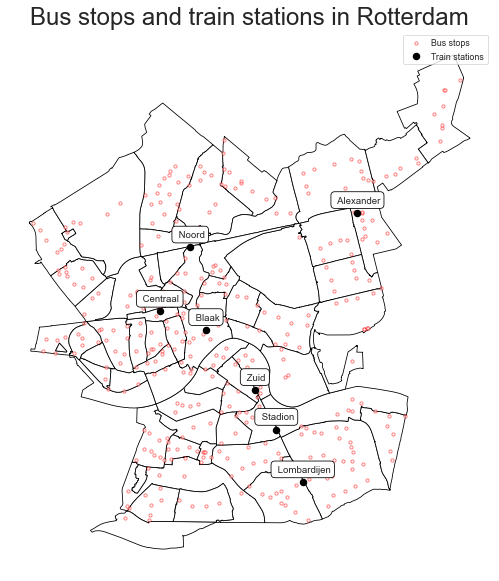

In [44]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.set_context("paper")
sns.set_style("white")
buurt_shp2.to_crs('EPSG:28992').plot(ax=ax, color='white', edgecolor='black')
geo_stops.to_crs('EPSG:28992').plot(ax=ax, label="Bus stops", marker='o', alpha=0.5, color='white', edgecolor='red', linewidth=1, markersize=10)
geo_stations.to_crs('EPSG:28992').plot(ax=ax, label="Train stations", marker='o', color='black', linewidth=3, markersize=20)
ax.legend()

ax.set_title(f"Bus stops and train stations in {city}", fontsize=24)

# Plot stations
geo_stations.to_crs('EPSG:28992').apply(
        lambda x: ax.annotate(
            #s=f"{x.korte_naam}\n({x.type.replace('station','')})",
            s=f"{x.naam.replace('Rotterdam','')}",
            xy=np.array(x.geometry.centroid.coords[0])+np.array([0, 300]),
            ha='center',
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                boxstyle='round,pad=0.4'
            )
        ),
        axis=1
    )
ax.axis("off")

In [45]:
wijk_shp

,GM_NAAM,WK_CODE,WK_NAAM,AANT_INW,geometry,share_residents
1462,Rotterdam,WK059901,Rotterdam Centrum,35050,"POLYGON ((91412.788 437507.740, 91406.180 4375...",0.060269
1463,Rotterdam,WK059903,Delfshaven,76215,"POLYGON ((89158.883 436492.503, 89145.772 4364...",0.131053
1464,Rotterdam,WK059904,Overschie,18840,"POLYGON ((87962.448 440438.639, 87890.050 4403...",0.032396
1465,Rotterdam,WK059905,Noord,52025,"POLYGON ((91300.683 439410.347, 91757.468 4395...",0.089458
1466,Rotterdam,WK059906,Hillegersberg-Schiebroek,44475,"POLYGON ((91239.000 440237.689, 91239.000 4402...",0.076475
1467,Rotterdam,WK059908,Kralingen-Crooswijk,54215,"POLYGON ((93015.124 438345.351, 93014.008 4383...",0.093223
1468,Rotterdam,WK059910,Feijenoord,75530,"POLYGON ((92994.584 436176.174, 93001.000 4361...",0.129875
1469,Rotterdam,WK059912,IJsselmonde,60840,"POLYGON ((95433.522 434054.706, 95413.068 4340...",0.104615
1471,Rotterdam,WK059914,Prins Alexander,95775,"POLYGON ((96393.260 439120.118, 96381.741 4391...",0.164686
1472,Rotterdam,WK059915,Charlois,68595,"MULTIPOLYGON (((88818.532 434027.283, 88812.37...",0.117950


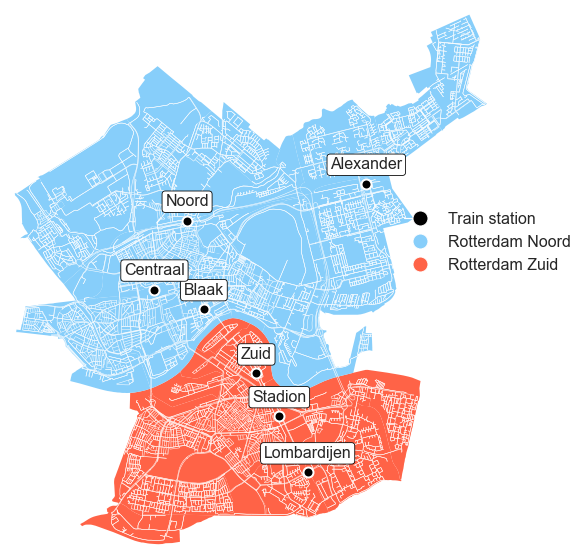

<Figure size 432x288 with 0 Axes>

In [46]:
sns.set_context("paper")
sns.set_style("white")

colors = {"n":"white", "z": "tomato", "rn": "lightskyblue", "s":'black', "street":"white"}
#colors = {"n":"red", "z": "mistyrose", "rn": "aliceblue", "s":'black'}

# Plot street network projection
fig_snet, ax_snet = ox.plot_graph(
    G_proj,
    fig_height=10,
    #margin=0.2,
    node_color=colors["street"],
    node_size=0,
    edge_linewidth=0.5,
    node_zorder=0,
    edge_color=colors["street"],
    show=False,
    close=False,
)#, node_edgecolor='k', edge_color='#777777')
plt.close()

# Plot district boundaries
# wijk_shp.geometry.boundary.plot(ax=ax_snet, color=colors["n"], linewidth=4,zorder=-50)

# Plot district boundaries
buurt_shp.loc[buurt_shp["WK_NAAM"].isin(zuid_districts)].plot(ax=ax_snet, color=colors["z"], alpha=1, linewidth=0,zorder=-100)
buurt_shp.loc[~buurt_shp["WK_NAAM"].isin(zuid_districts)].plot(ax=ax_snet, color=colors["rn"], alpha=1, linewidth=0,zorder=-100)

# Plot stations
geo_stations.to_crs('EPSG:28992').apply(
        lambda x: ax_snet.annotate(
            #s=f"{x.korte_naam}\n({x.type.replace('station','')})",
            s=f"{x.naam.replace('Rotterdam ','')}",
            xy=np.array(x.geometry.centroid.coords[0])+np.array([0, 400]),
            ha='center',
            fontsize=16,
            zorder=300,
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                boxstyle='round,pad=0.2'
            )
        ),
        axis=1
    )
ax.axis("off")

from matplotlib.lines import Line2D

legend_elements = [
    # Line2D([0], [0], color=colors["n"], lw=4, label='Neighborhoods'),
    Line2D([0], [0], marker='o', color="white", markerfacecolor=colors["s"], label='Train station', markersize=15, zorder=300), #markerfacecolor='g',,
    Line2D([0], [0], marker='o', color="white", markerfacecolor=colors["rn"], label='Rotterdam Noord', markersize=15, zorder=300), #markerfacecolor='g',,
    Line2D([0], [0], marker='o', color="white", markerfacecolor=colors["z"], label='Rotterdam Zuid', markersize=15, zorder=300), #markerfacecolor='g',,
]

ax2 = geo_stations.to_crs('EPSG:28992').plot(ax=ax_snet, zorder=200, label="b", marker='o', edgecolor="white", color=colors["s"], linewidth=2, markersize=100)
ax2.legend(handles=legend_elements, loc=(0.8, 1/2), fontsize=16, frameon=False)
fig_snet.savefig(path_station_noord_zuid, bbox_inches="tight", pad_inches=0)
fig_snet

In [47]:
# Plot bus stops
geo_stops.to_crs('EPSG:28992').apply(
        lambda x: ax.annotate(
            s=f"{x['name'].replace('Rotterdam, ','')}",
            xy=np.array(x.geometry.centroid.coords[0])+np.array([0, 0.005]),
            ha='center',
        ),
        axis=1
    )

ax.axis("off")
plt.show()

## Find closest station to each node

In [48]:
# Copy of stations dataframe
s = copy.deepcopy(geo_stations)

def closest_station(node_id):
    # Distance in km of node_id from station.node_id
    s["dist"] = s.apply(
        lambda x:nx.dijkstra_path_length(
            G,
            source=node_id,
            target=x.node_id,
            weight="length"
        )/1000,
        axis=1
    )
    
    # Get the id of closest node
    a = s[s["dist"] == min(s["dist"])]
    
    # Closest node and distance
    return int(a.iloc[0]["node_id"]), a.iloc[0]["dist"]

# Station node and distance to station
df_geo2 = copy.deepcopy(geo_points_hex)
df_geo2[["station_node", "dist_station_km"]] = df_geo2.apply(
    lambda x:closest_station(x.id),
    axis=1,
    result_type="expand"
)

df_geo2["station_node"] = df_geo2["station_node"].astype(int)
df_geo2.sort_values(by=["id", "hex_07", "hex_08", "hex_09"], inplace=True)
df_geo2[[
    "id", "lon", "lat", "WK_NAAM", "BU_NAAM", "station_node", "dist_station_km",
    "hex_07", "hex_08", "hex_09",
    # "centroid_07", "centroid_08", "centroid_09",
    "centroid_node_07", "centroid_node_08", "centroid_node_09",]
].rename(columns={"WK_NAAM":"district", "BU_NAAM":"neighborhood"}).to_csv(path_node_station_hex, index=False)

df_geo2

,id,lon,lat,geometry,WK_NAAM,BU_NAAM,hex_09,geo_09,centroid_09,centroid_node_09,...,centroid_08,centroid_node_08,centroid_node_gps_08,hex_07,geo_07,centroid_07,centroid_node_07,centroid_node_gps_07,station_node,dist_station_km
11219,0,4.556128,51.888559,POINT (4.55613 51.88856),IJsselmonde,Groot IJsselmonde,89196bb5c8bffff,"POLYGON ((4.551200299491461 51.8890517784516, ...",POINT (4.553725172435525 51.88858295360058),1271,...,POINT (4.558448346307102 51.88924278016209),1354,POINT (4.5581365 51.8894494),87196bb5cffffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.54998416339768 51.88312893419094),838,POINT (4.550623 51.8830696),9701,2.895918
2916,1,4.556644,51.890392,POINT (4.55664 51.89039),IJsselmonde,Groot IJsselmonde,89196bb5c9bffff,"POLYGON ((4.553071522540672 51.89177826684732,...",POINT (4.555596517899619 51.89130944074267),1597,...,POINT (4.558448346307102 51.88924278016209),1354,POINT (4.5581365 51.8894494),87196bb5cffffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.54998416339768 51.88312893419094),838,POINT (4.550623 51.8830696),7351,3.011158
2920,2,4.554555,51.890036,POINT (4.55455 51.89004),IJsselmonde,Groot IJsselmonde,89196bb5c9bffff,"POLYGON ((4.553071522540672 51.89177826684732,...",POINT (4.555596517899619 51.89130944074267),1597,...,POINT (4.558448346307102 51.88924278016209),1354,POINT (4.5581365 51.8894494),87196bb5cffffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.54998416339768 51.88312893419094),838,POINT (4.550623 51.8830696),7351,2.865750
2927,3,4.553470,51.889854,POINT (4.55347 51.88985),IJsselmonde,Groot IJsselmonde,89196bb5c8bffff,"POLYGON ((4.551200299491461 51.8890517784516, ...",POINT (4.553725172435525 51.88858295360058),1271,...,POINT (4.558448346307102 51.88924278016209),1354,POINT (4.5581365 51.8894494),87196bb5cffffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.54998416339768 51.88312893419094),838,POINT (4.550623 51.8830696),7351,2.790741
4751,4,4.426126,51.915170,POINT (4.42613 51.91517),Delfshaven,Witte Dorp,89196ba2007ffff,"POLYGON ((4.424308306187035 51.9156011514897, ...",POINT (4.42683290041553 51.91513565024714),2925,...,POINT (4.423978714144117 51.91719699827949),3040,POINT (4.4242957 51.9170059),87196ba20ffffff,"POLYGON ((4.406306381300341 51.92045345841772,...",POINT (4.423979726344801 51.91719635376327),3040,POINT (4.4242957 51.9170059),10034,4.173367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9619,10355,4.541026,51.883727,POINT (4.54103 51.88373),IJsselmonde,Groot IJsselmonde,89196bb5c57ffff,"POLYGON ((4.539884618505602 51.88500452466931,...",POINT (4.542409223688013 51.88453589796229),7878,...,POINT (4.537687344981484 51.88387531134873),876,POINT (4.5381674 51.8837275),87196bb5cffffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.54998416339768 51.88312893419094),838,POINT (4.550623 51.8830696),9701,2.023130
9620,10356,4.541191,51.883264,POINT (4.54119 51.88326),IJsselmonde,Groot IJsselmonde,89196bb5c57ffff,"POLYGON ((4.539884618505602 51.88500452466931,...",POINT (4.542409223688013 51.88453589796229),7878,...,POINT (4.537687344981484 51.88387531134873),876,POINT (4.5381674 51.8837275),87196bb5cffffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.54998416339768 51.88312893419094),838,POINT (4.550623 51.8830696),9701,2.095251
9621,10357,4.540741,51.883568,POINT (4.54074 51.88357),IJsselmonde,Groot IJsselmonde,89196bb5c57ffff,"POLYGON ((4.539884618505602 51.88500452466931,...",POINT (4.542409223688013 51.88453589796229),7878,...,POINT (4.537687344981484 51.88387531134873),876,POINT (4.5381674 51.8837275),87196bb5cffffff,"POLYGON ((4.532310920941071 51.88640996736343,...",POINT (4.54998416339768 51.88312893419094),838,POINT (4.550623 51.8830696),9701,2.049494
9622,10358,4.540908,51.883103,POINT (4.54091 51.88310),IJsselmonde,Groot IJsselmonde,89196bb5c47ffff,"POLYGON ((4.538014294371637 51.88227772601192,...",POINT (4.54053877713901 51.8818

## Population in districts and neighborhoods

In [49]:
buurt_shp["share_residents"] = buurt_shp["AANT_INW"]/sum(buurt_shp["AANT_INW"])
wijk_shp["share_residents"] = wijk_shp["AANT_INW"]/sum(wijk_shp["AANT_INW"])

C:\Users\LocalAdmin\anaconda3\envs\env_slevels\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\LocalAdmin\anaconda3\envs\env_slevels\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


MAX 0.16468636082261504
MAX: 0.049607026080354756


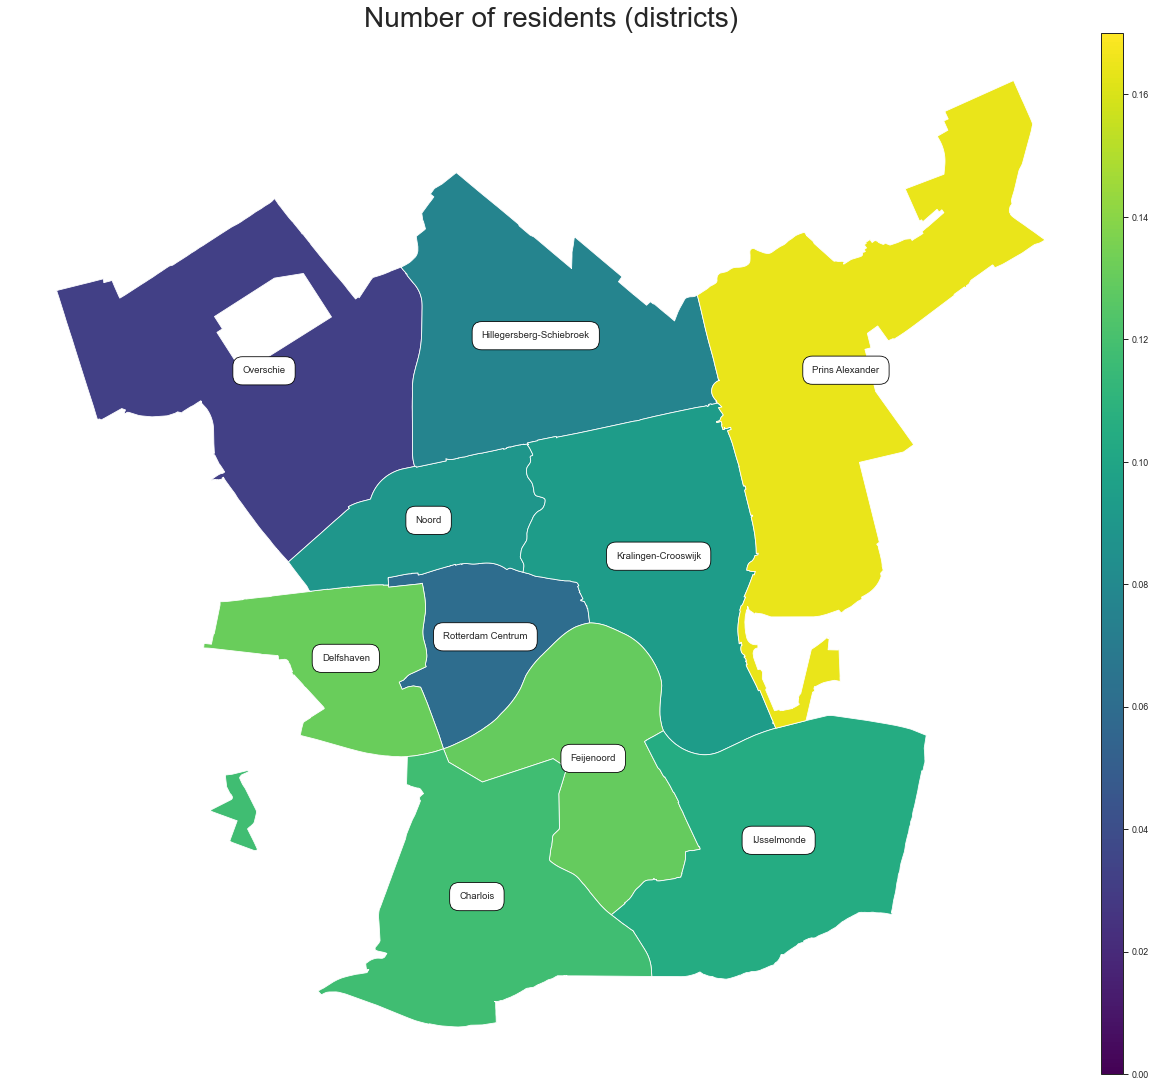

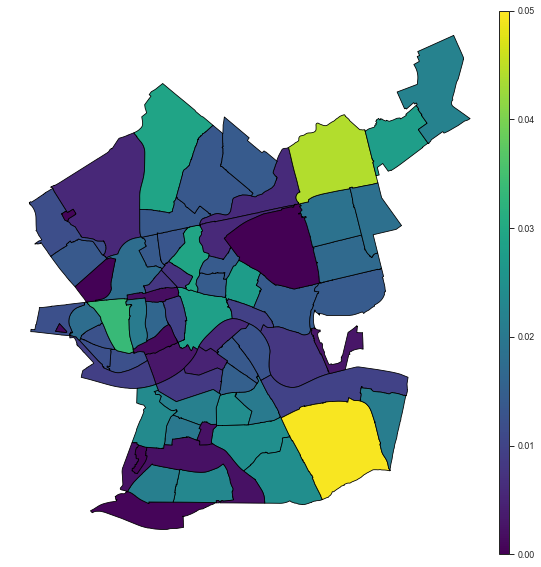

In [50]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig_w, ax_w = plt.subplots(1, 1, figsize=(20, 20))

sns.set_style("white")
sns.set_context("paper")


# Color based on
color_column = "share_residents"
# Setup population bar from districts
divider1 = make_axes_locatable(ax_w)
cax1 = divider1.append_axes("right", size="2%", pad=0.1)

print("MAX", max(wijk_shp[color_column]))
wijk_shp.plot(column=color_column, cmap="viridis",  vmin=0, vmax=0.17, ax=ax_w, legend=True, cax=cax1)
ax_w.axis("off")
ax_w.set_title("Number of residents (districts)", fontsize=28)


# Annotate district names
_ = wijk_shp.apply(
        lambda x: ax_w.annotate(
            s=x.WK_NAAM,
            xy=x.geometry.centroid.coords[0],
            ha='center',
            bbox=dict(
                facecolor='white',
                edgecolor='black',
                boxstyle='round,pad=1'
            )
        ),
        axis=1
    )

# Annotate neighborhood names
# _ = buurt_shp.apply(
#         lambda x: ax[1].annotate(
#             s=x.BU_NAAM,
#             xy=x.geometry.centroid.coords[0],
#             ha='center',
#             bbox=dict(
#                 facecolor='white',
#                 edgecolor='black',
#                 boxstyle='round,pad=0.2'
#             )
#         ),
#         axis=1
#     )


fig_res, ax_res = plt.subplots(1, 1, figsize=(10, 10))

# Setup population bar from neighborhoods
print("MAX:", max(buurt_shp[color_column]))
divider2 = make_axes_locatable(ax_res)
cax2 = divider2.append_axes("right", size="2%", pad=0.1)
buurt_shp.plot(column=color_column, cmap="viridis", edgecolor="black", legend=True, vmin=0, vmax=0.05, ax=ax_res, cax=cax2) # for grayscale use: cmap=binary


ax_res.axis("off")
#ax[1].set_title("Number of residents (neighborhoods)", fontsize=28)


fig_res.savefig(path_img_residents, bbox_inches="tight", pad_inches=0)